In [181]:
#Import the required modules for data generation
import numpy as np
#Import the required modules for plot creation:
import matplotlib.pyplot as plt
#Import the required modules for DataFrame creation:
import pandas as pd

#Import the required modules for TimeSeries data generation:
import statsmodels.api as sm
#Import the required modules for test statistic calculation:
import statsmodels.stats as sm_stat
#Import the required modules for model estimation:
import statsmodels.tsa as smt
#Import the required modules for optimization:
import scipy as scipy
#We also need additional data:
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

from bcb import currency
from bcb import sgs

import yfinance as yf
import fix_yahoo_finance as yf
import pandas_datareader.data as web

import datetime


In [236]:
vix = yf.download("VIX", start="2002-01-01", end="2023-06-25")
vix.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-04,28200.400391,30096.900391,27953.0,28447.699219,28447.699219,811330
2014-12-05,26551.199219,27540.699219,25974.0,26056.500000,26056.500000,377529


Os dados utilizados foram obtidos da API do banco central e Ipea. 

Variáveis:
- Câmbio Ok
- Índice de produção da indústria de transformação (demanda) Ok
- Selic Ok 
- Desembolso de crédito direcionado do BNDES para indústria de transformação Ok
- Vix (adquirir)
- Embi (risco) Ok
- Exportação industria de transformação (adquirir) 

In [197]:
#ETL dos dados obs.:
df = sgs.get({'bndes_industria':7416, 'indice_ind_transf':28505}, 
             start ='1995-01-31', end='2023-06-30')
df.dropna(inplace=True)
df = df.resample('1M').mean()
curr = currency.get(['USD'], start = '1995-01-31', end = '2023-06-30')
selic = pd.read_excel('../dados/selic_acum_ipea.xlsx')
embi = pd.read_excel('../dados/embi_risco.xlsx')
selic.set_index('data', inplace=True)
embi.set_index('data', inplace=True)
selic = selic.resample('1M').mean()
curr = curr.resample('1M').mean()
embi = embi.resample('1M').mean()
df['cambio'] = curr['USD']
df['selic_acum'] = selic['selic_acum']
df['embi_risco'] = embi['embi_risco']
df.head(2)

,bndes_industria,indice_ind_transf,cambio,selic_acum,embi_risco
Date,,,,,
2002-01-31,1024.0,91.8,2.377932,1.53,845.363636
2002-02-28,1792.0,94.2,2.419600,1.25,842.800000


In [276]:
def teste_estacionariedade (serie, titulo):
    adf = adfuller(serie, autolag='AIC')
    test_adf = adf[4]
    test_adf = test_adf['5%']
    if (test_adf > adf[1]):
        print('A Série de '+ titulo +' é estacionária')
    else:
        print('A Série de '+ titulo +' não é estacionária')
    print('Teste adf: ' + str(adf[1]) + '| %5: '+ str(test_adf)
          )

In [277]:
teste_estacionariedade (df['bndes_industria'], 'Desembolso do BNDES')
teste_estacionariedade (df['indice_ind_transf'], 'Índice de transformação industrial')
teste_estacionariedade (df['cambio'], 'Câmbio')
teste_estacionariedade (df['selic_acum'], 'Selic acumulada')
teste_estacionariedade (df['embi_risco'], 'Risco Brasil')

A Série de Desembolso do BNDES não é estacionária
Teste adf: 0.4274307722577201| %5: -2.873918902362675
A Série de Índice de transformação industrial não é estacionária
Teste adf: 0.11657644672874945| %5: -2.8731248767783426
A Série de Câmbio não é estacionária
Teste adf: 0.9603602967615709| %5: -2.8738137461081323
A Série de Selic acumulada não é estacionária
Teste adf: 0.038353620165062725| %5: -2.8737103617125186
A Série de Risco Brasil não é estacionária
Teste adf: 0.020384249465288048| %5: -2.8731715065600003


Diferenciando a série para tornar estacionária

In [278]:
log_df = np.log(df)
log_df.dropna(inplace=True)

In [279]:
diff_df = df.diff()
diff_df.dropna(inplace=True)

In [280]:
teste_estacionariedade (log_df['bndes_industria'], 'Desembolso do BNDES')
teste_estacionariedade (log_df['indice_ind_transf'], 'Índice de transformação industrial')
teste_estacionariedade (log_df['cambio'], 'Câmbio')
teste_estacionariedade (log_df['selic_acum'], 'Selic acumulada')
teste_estacionariedade (log_df['embi_risco'], 'Risco Brasil')

A Série de Desembolso do BNDES não é estacionária
Teste adf: 0.5086502303900028| %5: -2.8737103617125186
A Série de Índice de transformação industrial não é estacionária
Teste adf: 0.06352659731753874| %5: -2.8731248767783426
A Série de Câmbio não é estacionária
Teste adf: 0.8654155200449856| %5: -2.8731715065600003
A Série de Selic acumulada não é estacionária
Teste adf: 0.26221276510567093| %5: -2.873918902362675
A Série de Risco Brasil não é estacionária
Teste adf: 0.07817960595065909| %5: -2.8731715065600003


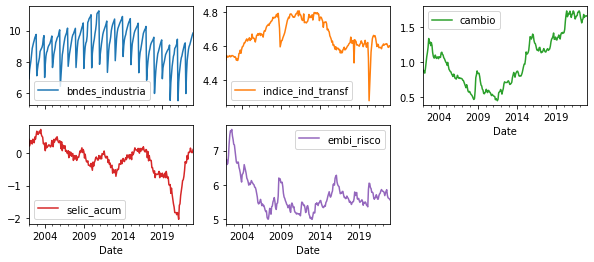

In [275]:
log_df.plot(subplots=True, layout=(2, 3), figsize=(10,4));

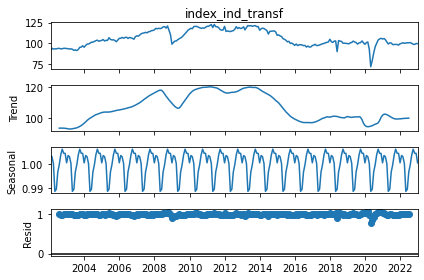

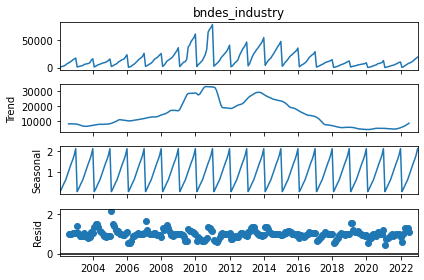

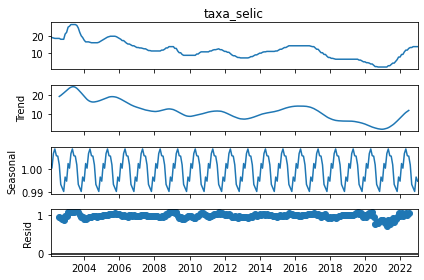

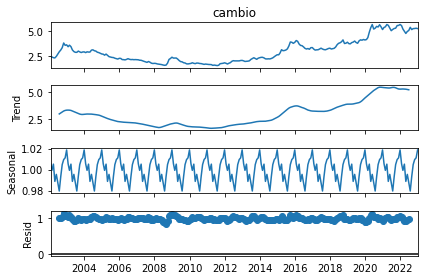

In [134]:
ts1 = seasonal_decompose(df.index_ind_transf, model='multiplicative')
ts1.plot()
ts2 = seasonal_decompose(df.bndes_industry, model='multiplicative')
ts2.plot()
ts3 = seasonal_decompose(df.taxa_selic, model='multiplicative')
ts3.plot()
ts4 = seasonal_decompose(df.cambio, model='multiplicative')
ts4.plot()
pyplot.show()

In [122]:
model = VAR(df)

In [123]:
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 27, Jun, 2023
Time:                     00:52:42
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    15.1194
Nobs:                     250.000    HQIC:                   14.8164
Log likelihood:          -3209.48    FPE:                2.21875e+06
AIC:                      14.6123    Det(Omega_mle):     1.92606e+06
--------------------------------------------------------------------
Results for equation bndes_industry
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                   -6482.391602     18541.460699           -0.350           0.727
L1.bndes_industry           0.733624         0.064056           11.453           0.000
L1.index_ind_transf       2

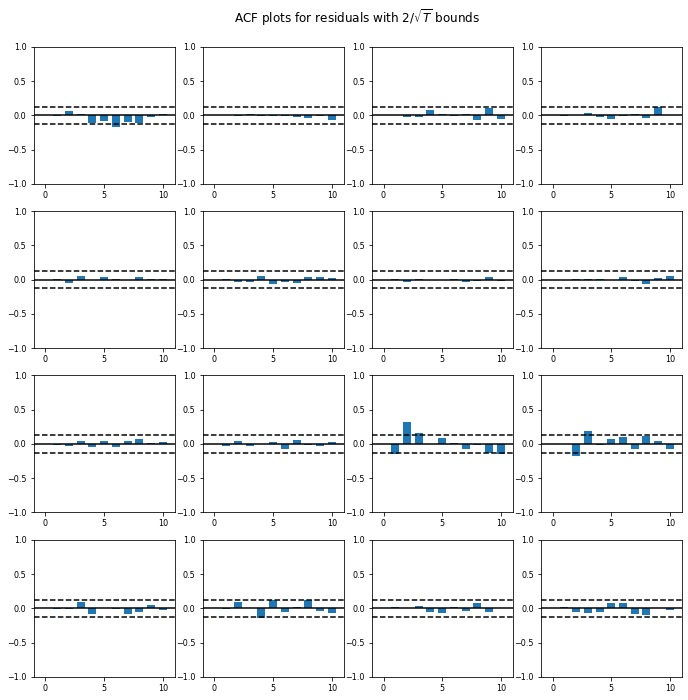

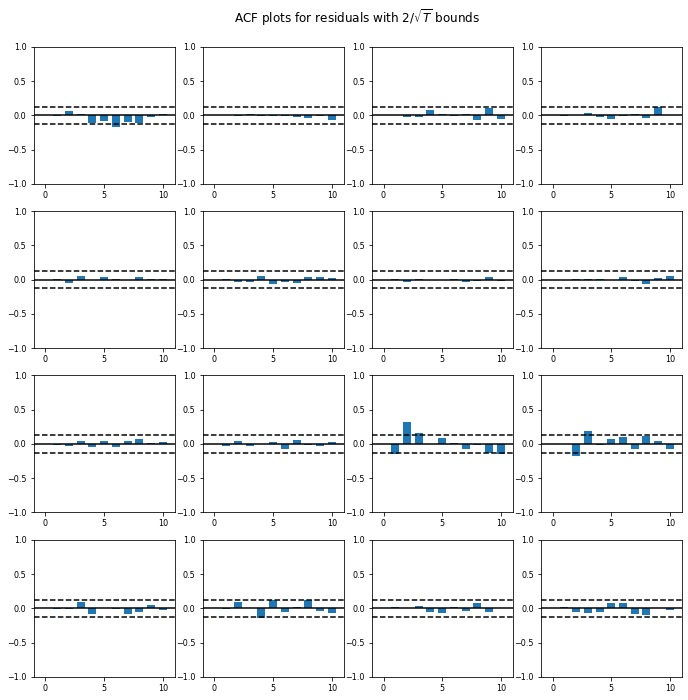

In [124]:
results.plot_acorr()

In [125]:
fevd = results.fevd(5)
fevd.summary()

FEVD for bndes_industry
     bndes_industry  index_ind_transf  taxa_selic    cambio
0          1.000000          0.000000    0.000000  0.000000
1          0.994486          0.003987    0.001527  0.000000
2          0.987207          0.009307    0.003029  0.000456
3          0.979083          0.015448    0.003650  0.001819
4          0.970446          0.021694    0.003739  0.004121

FEVD for index_ind_transf
     bndes_industry  index_ind_transf  taxa_selic    cambio
0          0.000004          0.999996    0.000000  0.000000
1          0.001036          0.968794    0.000070  0.030100
2          0.003942          0.940267    0.000227  0.055564
3          0.007138          0.914243    0.001078  0.077541
4          0.009682          0.889687    0.002698  0.097932

FEVD for taxa_selic
     bndes_industry  index_ind_transf  taxa_selic    cambio
0          0.003174          0.000035    0.996791  0.000000
1          0.001748          0.000306    0.990419  0.007526
2          0.000972         

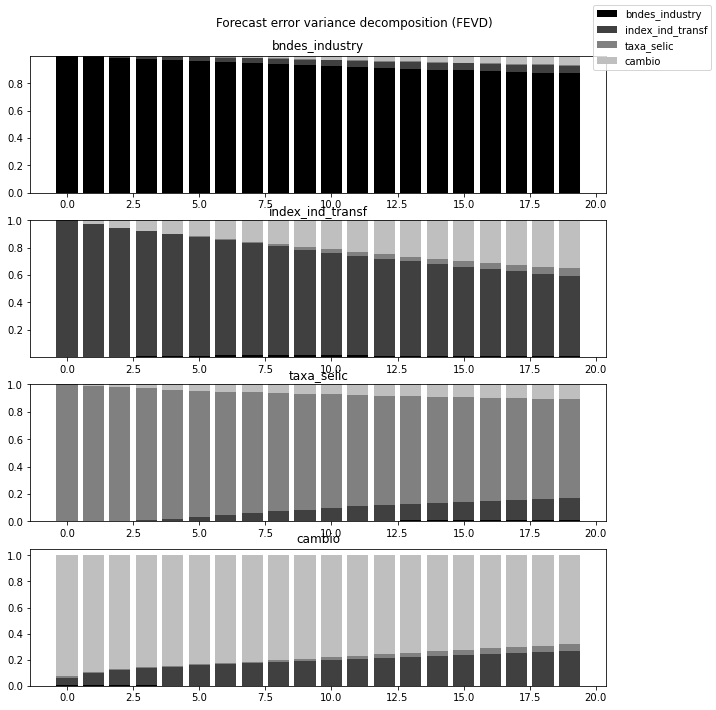

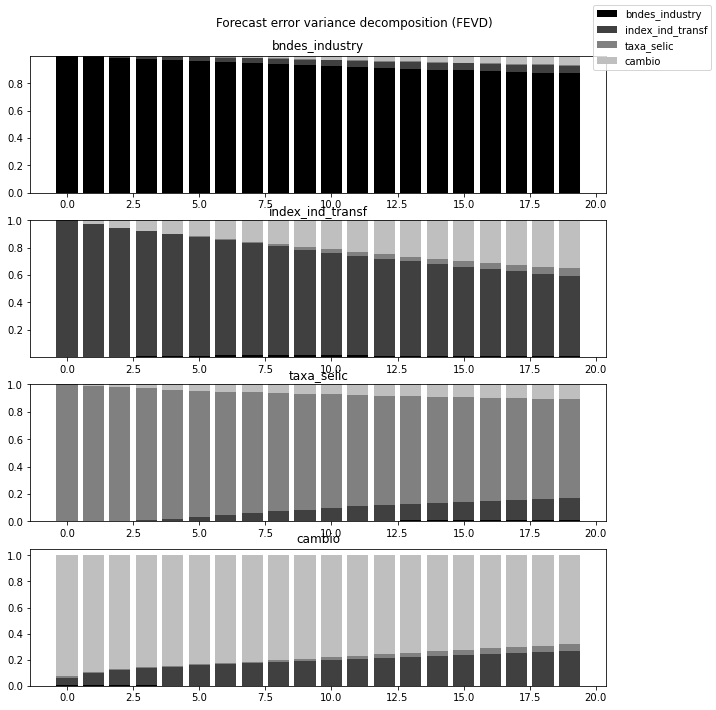

In [126]:
results.fevd(20).plot()

In [68]:
df.cov()

,bndes_industry,index_ind_transf,taxa_selic,cambio
bndes_industry,1.961201e+08,61711.873440,-4450.034149,-6155.428456
index_ind_transf,6.171187e+04,86.775573,-11.817198,-7.215828
taxa_selic,-4.450034e+03,-11.817198,26.423236,-1.899613
cambio,-6.155428e+03,-7.215828,-1.899613,1.338617


In [69]:
Y_VAR = smt.api.VAR(df)

In [70]:
results = Y_VAR.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 27, Jun, 2023
Time:                     00:15:32
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    15.1194
Nobs:                     250.000    HQIC:                   14.8164
Log likelihood:          -3209.48    FPE:                2.21875e+06
AIC:                      14.6123    Det(Omega_mle):     1.92606e+06
--------------------------------------------------------------------
Results for equation bndes_industry
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                   -6482.391602     18541.460699           -0.350           0.727
L1.bndes_industry           0.733624         0.064056           11.453           0.000
L1.index_ind_transf       2

In [71]:
results.resid.cov()

,bndes_industry,index_ind_transf,taxa_selic,cambio
bndes_industry,8.434953e+07,-45.597855,-242.310263,73.596054
index_ind_transf,-4.559786e+01,6.269869,-0.006794,-0.076486
taxa_selic,-2.423103e+02,-0.006794,0.219308,-0.005675
cambio,7.359605e+01,-0.076486,-0.005675,0.015757


In [72]:
results.resid.mean()

bndes_industry     -4.998583e-12
index_ind_transf    2.654588e-14
taxa_selic          1.190159e-14
cambio              1.465494e-15
dtype: float64

In [73]:
irf = results.irf(15)

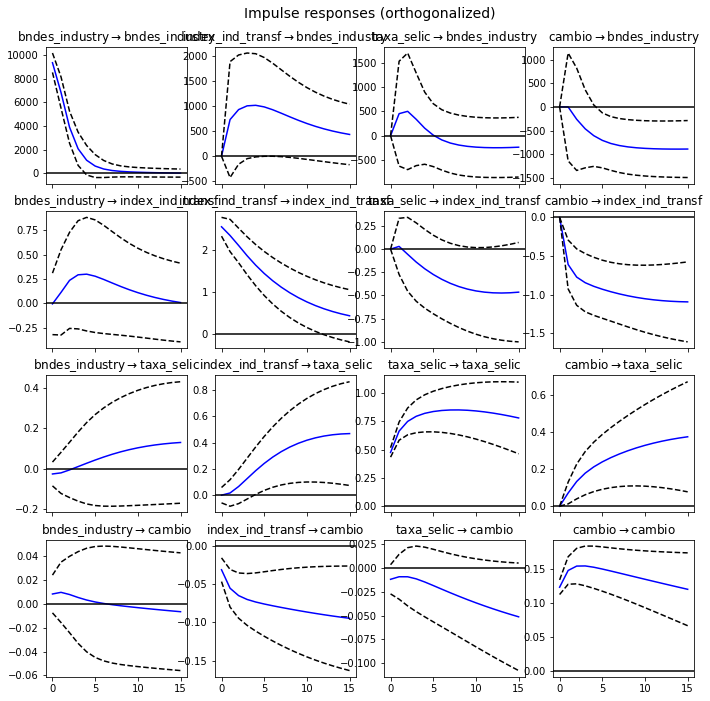

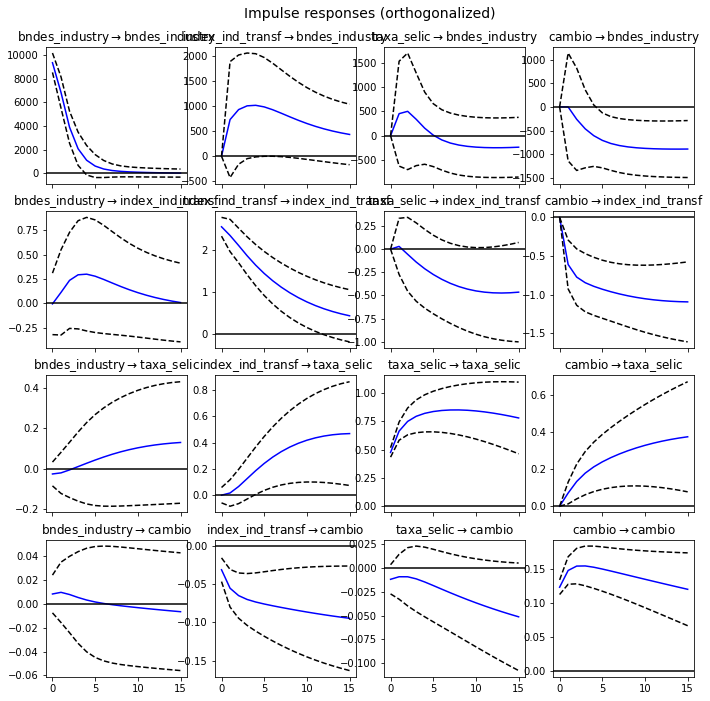

In [75]:
irf.plot(orth = True)

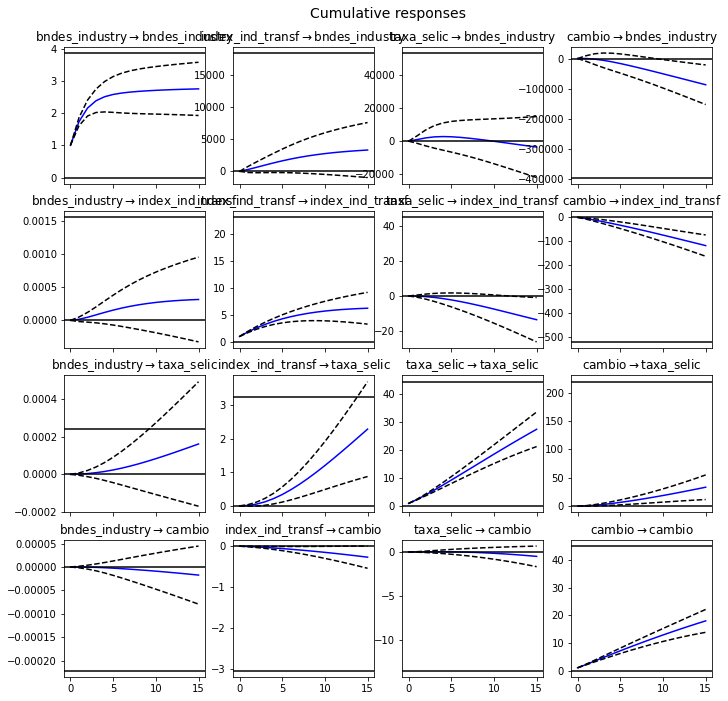

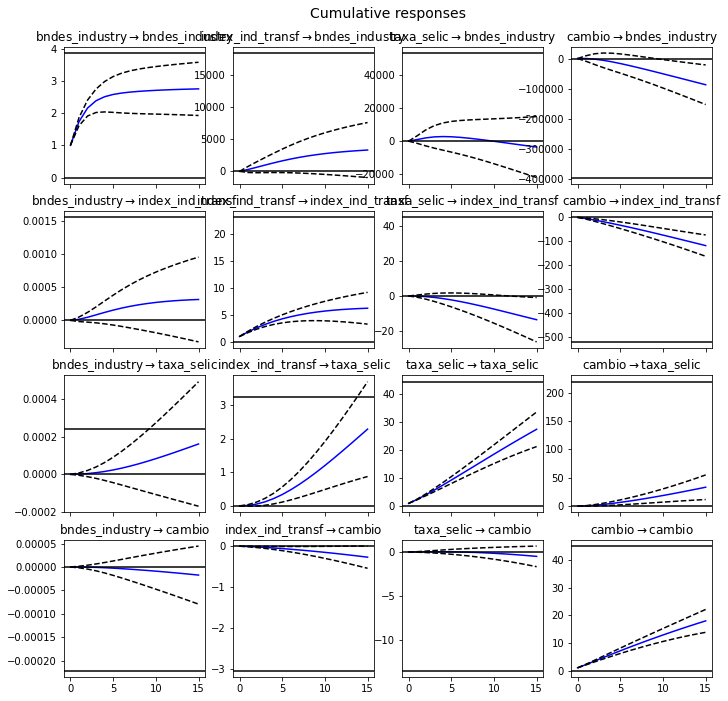

In [76]:
irf.plot_cum_effects(orth = False)

(425.0, 274.05)

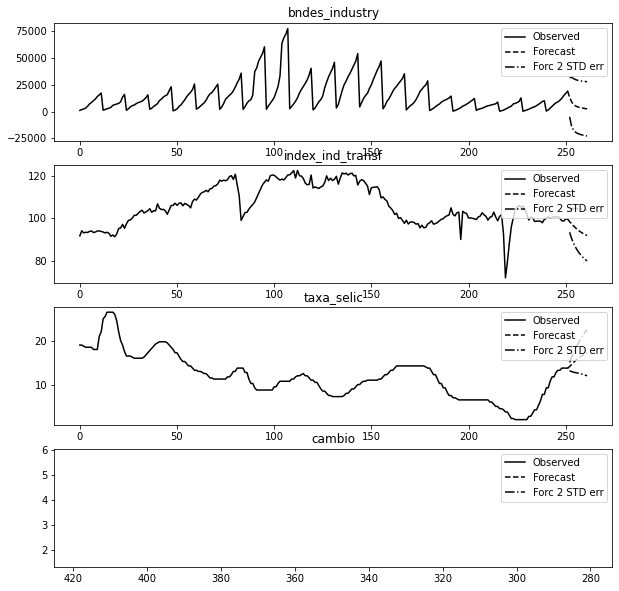

In [77]:
results.plot_forecast(10)
plt.xlim(xmin = 425) # we can subset the last variable forecast plot

#### VECM

In [79]:
# -*- coding: utf-8 -*-
from collections import defaultdict

import numpy as np
from numpy import hstack, vstack
from numpy.linalg import inv, svd
import scipy
import scipy.stats

from statsmodels.iolib.summary import Summary
from statsmodels.iolib.table import SimpleTable
from statsmodels.tools.decorators import cache_readonly
from statsmodels.tools.sm_exceptions import HypothesisTestWarning
from statsmodels.tools.validation import string_like
import statsmodels.tsa.base.tsa_model as tsbase
from statsmodels.tsa.coint_tables import c_sja, c_sjt
from statsmodels.tsa.tsatools import duplication_matrix, lagmat, vec
from statsmodels.tsa.vector_ar.hypothesis_test_results import (
    CausalityTestResults,
    WhitenessTestResults,
)
import statsmodels.tsa.vector_ar.irf as irf
import statsmodels.tsa.vector_ar.plotting as plot
from statsmodels.tsa.vector_ar.util import get_index, seasonal_dummies
from statsmodels.tsa.vector_ar.var_model import (
    VAR,
    LagOrderResults,
    _compute_acov,
    forecast,
    forecast_interval,
    ma_rep,
    orth_ma_rep,
    test_normality,
)

def select_order(
    data,
    maxlags: int,
    deterministic: str = "n",
    seasons: int = 0,
    exog=None,
    exog_coint=None,
):
    """
    Compute lag order selections based on each of the available information
    criteria.

    Parameters
    ----------
    data : array_like (nobs_tot x neqs)
        The observed data.
    maxlags : int
        All orders until maxlag will be compared according to the information
        criteria listed in the Results-section of this docstring.
    deterministic : str {"n", "co", "ci", "lo", "li"}
        * ``"n"`` - no deterministic terms
        * ``"co"`` - constant outside the cointegration relation
        * ``"ci"`` - constant within the cointegration relation
        * ``"lo"`` - linear trend outside the cointegration relation
        * ``"li"`` - linear trend within the cointegration relation

        Combinations of these are possible (e.g. ``"cili"`` or ``"colo"`` for
        linear trend with intercept). See the docstring of the
        :class:`VECM`-class for more information.
    seasons : int, default: 0
        Number of periods in a seasonal cycle.
    exog : ndarray (nobs_tot x neqs) or `None`, default: `None`
        Deterministic terms outside the cointegration relation.
    exog_coint : ndarray (nobs_tot x neqs) or `None`, default: `None`
        Deterministic terms inside the cointegration relation.

    Returns
    -------
    selected_orders : :class:`statsmodels.tsa.vector_ar.var_model.LagOrderResults`
    """
    ic = defaultdict(list)
    deterministic = string_like(deterministic, "deterministic")
    for p in range(1, maxlags + 2):  # +2 because k_ar_VECM == k_ar_VAR - 1
        exogs = []
        if "co" in deterministic or "ci" in deterministic:
            exogs.append(np.ones(len(data)).reshape(-1, 1))
        if "lo" in deterministic or "li" in deterministic:
            exogs.append(1 + np.arange(len(data)).reshape(-1, 1))
        if exog_coint is not None:
            exogs.append(exog_coint)
        if seasons > 0:
            exogs.append(
                seasonal_dummies(seasons, len(data)).reshape(-1, seasons - 1)
            )
        if exog is not None:
            exogs.append(exog)
        exogs = hstack(exogs) if exogs else None
        var_model = VAR(data, exogs)
        # exclude some periods ==> same amount of data used for each lag order
        var_result = var_model._estimate_var(lags=p, offset=maxlags + 1 - p)

        for k, v in var_result.info_criteria.items():
            ic[k].append(v)
    # -1+1 in the following line is only here for clarification.
    # -1 because k_ar_VECM == k_ar_VAR - 1
    # +1 because p == index +1 (we start with p=1, not p=0)
    selected_orders = dict(
        (ic_name, np.array(ic_value).argmin() - 1 + 1)
        for ic_name, ic_value in ic.items()
    )

    return LagOrderResults(ic, selected_orders, True)

def select_coint_rank(
    endog, det_order, k_ar_diff, method="trace", signif=0.05
):
    """Calculate the cointegration rank of a VECM.

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        The data with presample.
    det_order : int
        * -1 - no deterministic terms
        * 0 - constant term
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
    method : str, {``"trace"``, ``"maxeig"``}, default: ``"trace"``
        If ``"trace"``, the trace test statistic is used. If ``"maxeig"``, the
        maximum eigenvalue test statistic is used.
    signif : float, {0.1, 0.05, 0.01}, default: 0.05
        The test's significance level.

    Returns
    -------
    rank : :class:`CointRankResults`
        A :class:`CointRankResults` object containing the cointegration rank suggested
        by the test and allowing a summary to be printed.
    """
    if method not in ["trace", "maxeig"]:
        raise ValueError(
            "The method argument has to be either 'trace' or"
            "'maximum eigenvalue'."
        )

    if det_order not in [-1, 0, 1]:
        if type(det_order) == int and det_order > 1:
            raise ValueError(
                "A det_order greather than 1 is not supported."
                "Use a value of -1, 0, or 1."
            )
        else:
            raise ValueError("det_order must be -1, 0, or 1.")

    possible_signif_values = [0.1, 0.05, 0.01]
    if signif not in possible_signif_values:
        raise ValueError(
            "Please choose a significance level from {0.1, 0.05," "0.01}"
        )

    coint_result = coint_johansen(endog, det_order, k_ar_diff)
    test_stat = coint_result.lr1 if method == "trace" else coint_result.lr2
    crit_vals = coint_result.cvt if method == "trace" else coint_result.cvm
    signif_index = possible_signif_values.index(signif)

    neqs = endog.shape[1]
    r_0 = 0  # rank in null hypothesis
    while r_0 < neqs:
        if test_stat[r_0] < crit_vals[r_0, signif_index]:
            break  # we accept current rank
        else:
            r_0 += 1  # we reject current rank and test next possible rank

    return CointRankResults(
        r_0,
        neqs,
        test_stat[: r_0 + 1],
        crit_vals[: r_0 + 1, signif_index],
        method,
        signif,
    )

def coint_johansen(endog, det_order, k_ar_diff):
    """
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms
        * 0 - constant term
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.

    Returns
    -------
    result : JohansenTestResult
        An object containing the test's results. The most important attributes
        of the result class are:

        * trace_stat and trace_stat_crit_vals
        * max_eig_stat and max_eig_stat_crit_vals

    Notes
    -----
    The implementation might change to make more use of the existing VECM
    framework.

    See Also
    --------
    statsmodels.tsa.vector_ar.vecm.select_coint_rank

    References
    ----------
    .. [1] Lütkepohl, H. 2005. New Introduction to Multiple Time Series
        Analysis. Springer.
    """
    import warnings

    if det_order not in [-1, 0, 1]:
        warnings.warn(
            "Critical values are only available for a det_order of "
            "-1, 0, or 1.",
            category=HypothesisTestWarning,
            stacklevel=2,
        )
    if endog.shape[1] > 12:  # todo: test with a time series of 13 variables
        warnings.warn(
            "Critical values are only available for time series "
            "with 12 variables at most.",
            category=HypothesisTestWarning,
            stacklevel=2,
        )

    from statsmodels.regression.linear_model import OLS

    def detrend(y, order):
        if order == -1:
            return y
        return (
            OLS(y, np.vander(np.linspace(-1, 1, len(y)), order + 1))
            .fit()
            .resid
        )

    def resid(y, x):
        if x.size == 0:
            return y
        r = y - np.dot(x, np.dot(np.linalg.pinv(x), y))
        return r

    endog = np.asarray(endog)
    nobs, neqs = endog.shape

    # why this?  f is detrend transformed series, det_order is detrend data
    if det_order > -1:
        f = 0
    else:
        f = det_order

    endog = detrend(endog, det_order)
    dx = np.diff(endog, 1, axis=0)
    z = lagmat(dx, k_ar_diff)
    z = z[k_ar_diff:]
    z = detrend(z, f)

    dx = dx[k_ar_diff:]

    dx = detrend(dx, f)
    r0t = resid(dx, z)
    # GH 5731, [:-0] does not work, need [:t-0]
    lx = endog[: (endog.shape[0] - k_ar_diff)]
    lx = lx[1:]
    dx = detrend(lx, f)
    rkt = resid(dx, z)  # level on lagged diffs
    # Level covariance after filtering k_ar_diff
    skk = np.dot(rkt.T, rkt) / rkt.shape[0]
    # Covariacne between filtered and unfiltered
    sk0 = np.dot(rkt.T, r0t) / rkt.shape[0]
    s00 = np.dot(r0t.T, r0t) / r0t.shape[0]
    sig = np.dot(sk0, np.dot(inv(s00), sk0.T))
    tmp = inv(skk)
    au, du = np.linalg.eig(np.dot(tmp, sig))  # au is eval, du is evec

    temp = inv(np.linalg.cholesky(np.dot(du.T, np.dot(skk, du))))
    dt = np.dot(du, temp)

    # JP: the next part can be done much  easier
    auind = np.argsort(au)
    aind = np.flipud(auind)
    a = au[aind]
    d = dt[:, aind]
    # Normalize by first non-zero element of d, usually [0, 0]
    # GH 5517
    non_zero_d = d.flat != 0
    if np.any(non_zero_d):
        d *= np.sign(d.flat[non_zero_d][0])

    #  Compute the trace and max eigenvalue statistics
    lr1 = np.zeros(neqs)
    lr2 = np.zeros(neqs)
    cvm = np.zeros((neqs, 3))
    cvt = np.zeros((neqs, 3))
    iota = np.ones(neqs)
    t, junk = rkt.shape
    for i in range(0, neqs):
        tmp = np.log(iota - a)[i:]
        lr1[i] = -t * np.sum(tmp, 0)
        lr2[i] = -t * np.log(1 - a[i])
        cvm[i, :] = c_sja(neqs - i, det_order)
        cvt[i, :] = c_sjt(neqs - i, det_order)
        aind[i] = i

    return JohansenTestResult(rkt, r0t, a, d, lr1, lr2, cvt, cvm, aind)

class JohansenTestResult:
    """
    Results class for Johansen's cointegration test

    Notes
    -----
    See p. 292 in [1]_ for r0t and rkt

    References
    ----------
    .. [1] Lütkepohl, H. 2005. New Introduction to Multiple Time Series
        Analysis. Springer.
    """

    def __init__(self, rkt, r0t, eig, evec, lr1, lr2, cvt, cvm, ind):
        self._meth = "johansen"
        self._rkt = rkt
        self._r0t = r0t
        self._eig = eig
        self._evec = evec
        self._lr1 = lr1
        self._lr2 = lr2
        self._cvt = cvt
        self._cvm = cvm
        self._ind = ind

    @property
    def rkt(self):
        """Residuals for :math:`Y_{-1}`"""
        return self._rkt

    @property
    def r0t(self):
        """Residuals for :math:`\\Delta Y`."""
        return self._r0t

    @property
    def eig(self):
        """Eigenvalues of VECM coefficient matrix"""
        return self._eig

    @property
    def evec(self):
        """Eigenvectors of VECM coefficient matrix"""
        return self._evec

    @property
    def trace_stat(self):
        """Trace statistic"""
        return self._lr1

    @property
    def lr1(self):
        """Trace statistic"""
        return self._lr1

    @property
    def max_eig_stat(self):
        """Maximum eigenvalue statistic"""
        return self._lr2

    @property
    def lr2(self):
        """Maximum eigenvalue statistic"""
        return self._lr2

    @property
    def trace_stat_crit_vals(self):
        """Critical values (90%, 95%, 99%) of trace statistic"""
        return self._cvt

    @property
    def cvt(self):
        """Critical values (90%, 95%, 99%) of trace statistic"""
        return self._cvt

    @property
    def cvm(self):
        """Critical values (90%, 95%, 99%) of maximum eigenvalue statistic."""
        return self._cvm

    @property
    def max_eig_stat_crit_vals(self):
        """Critical values (90%, 95%, 99%) of maximum eigenvalue statistic."""
        return self._cvm

    @property
    def ind(self):
        """Order of eigenvalues"""
        return self._ind

    @property
    def meth(self):
        """Test method"""
        return self._meth
    

class CointRankResults:
    """A class for holding the results from testing the cointegration rank.

    Parameters
    ----------
    rank : int (0 <= `rank` <= `neqs`)
        The rank to choose according to the Johansen cointegration rank
        test.
    neqs : int
        Number of variables in the time series.
    test_stats : array_like (`rank` + 1 if `rank` < `neqs` else `rank`)
        A one-dimensional array-like object containing the test statistics of
        the conducted tests.
    crit_vals : array_like (`rank` +1 if `rank` < `neqs` else `rank`)
        A one-dimensional array-like object containing the critical values
        corresponding to the entries in the `test_stats` argument.
    method : str, {``"trace"``, ``"maxeig"``}, default: ``"trace"``
        If ``"trace"``, the trace test statistic is used. If ``"maxeig"``, the
        maximum eigenvalue test statistic is used.
    signif : float, {0.1, 0.05, 0.01}, default: 0.05
        The test's significance level.
    """

    def __init__(
        self, rank, neqs, test_stats, crit_vals, method="trace", signif=0.05
    ):
        self.rank = rank
        self.neqs = neqs
        self.r_1 = [
            neqs if method == "trace" else i + 1
            for i in range(min(rank + 1, neqs))
        ]
        self.test_stats = test_stats
        self.crit_vals = crit_vals
        self.method = method
        self.signif = signif

    def summary(self):
        headers = ["r_0", "r_1", "test statistic", "critical value"]
        title = (
            "Johansen cointegration test using "
            + ("trace" if self.method == "trace" else "maximum eigenvalue")
            + " test statistic with {:.0%}".format(self.signif)
            + " significance level"
        )
        num_tests = min(self.rank, self.neqs - 1)
        data = [
            [i, self.r_1[i], self.test_stats[i], self.crit_vals[i]]
            for i in range(num_tests + 1)
        ]
        data_fmt = {
            "data_fmts": ["%s", "%s", "%#0.4g", "%#0.4g"],
            "data_aligns": "r",
        }
        html_data_fmt = dict(data_fmt)
        html_data_fmt["data_fmts"] = [
            "<td>" + i + "</td>" for i in html_data_fmt["data_fmts"]
        ]
        return SimpleTable(
            data=data,
            headers=headers,
            title=title,
            txt_fmt=data_fmt,
            html_fmt=html_data_fmt,
            ltx_fmt=data_fmt,
        )


    def __str__(self):
        return self.summary().as_text()

class VECMResults:
    """Class for holding estimation related results of a vector error
    correction model (VECM).

    Parameters
    ----------
    endog : ndarray (neqs x nobs_tot)
        Array of observations.
    exog : ndarray (nobs_tot x neqs) or `None`
        Deterministic terms outside the cointegration relation.
    exog_coint : ndarray (nobs_tot x neqs) or `None`
        Deterministic terms inside the cointegration relation.
    k_ar : int, >= 1
        Lags in the VAR representation. This implies that the number of lags in
        the VEC representation (=lagged differences) equals :math:`k_{ar} - 1`.
    coint_rank : int, 0 <= `coint_rank` <= neqs
        Cointegration rank, equals the rank of the matrix :math:`\\Pi` and the
        number of columns of :math:`\\alpha` and :math:`\\beta`.
    alpha : ndarray (neqs x `coint_rank`)
        Estimate for the parameter :math:`\\alpha` of a VECM.
    beta : ndarray (neqs x `coint_rank`)
        Estimate for the parameter :math:`\\beta` of a VECM.
    gamma : ndarray (neqs x neqs*(k_ar-1))
        Array containing the estimates of the :math:`k_{ar}-1` parameter
        matrices :math:`\\Gamma_1, \\dots, \\Gamma_{k_{ar}-1}` of a
        VECM(:math:`k_{ar}-1`). The submatrices are stacked horizontally from
        left to right.
    sigma_u : ndarray (neqs x neqs)
        Estimate of white noise process covariance matrix :math:`\\Sigma_u`.
    deterministic : str {``"n"``, ``"co"``, ``"ci"``, ``"lo"``, ``"li"``}
        * ``"n"`` - no deterministic terms
        * ``"co"`` - constant outside the cointegration relation
        * ``"ci"`` - constant within the cointegration relation
        * ``"lo"`` - linear trend outside the cointegration relation
        * ``"li"`` - linear trend within the cointegration relation

        Combinations of these are possible (e.g. ``"cili"`` or ``"colo"`` for
        linear trend with intercept). See the docstring of the
        :class:`VECM`-class for more information.
    seasons : int, default: 0
        Number of periods in a seasonal cycle. 0 means no seasons.
    first_season : int, default: 0
        Season of the first observation.
    delta_y_1_T : ndarray or `None`, default: `None`
        Auxiliary array for internal computations. It will be calculated if
        not given as parameter.
    y_lag1 : ndarray or `None`, default: `None`
        Auxiliary array for internal computations. It will be calculated if
        not given as parameter.
    delta_x : ndarray or `None`, default: `None`
        Auxiliary array for internal computations. It will be calculated if
        not given as parameter.
    model : :class:`VECM`
        An instance of the :class:`VECM`-class.
    names : list of str
        Each str in the list represents the name of a variable of the time
        series.
    dates : array_like
        For example a DatetimeIndex of length nobs_tot.

    Attributes
    ----------
    nobs : int
        Number of observations (excluding the presample).
    model : see Parameters
    y_all : see `endog` in Parameters
    exog : see Parameters
    exog_coint : see Parameters
    names : see Parameters
    dates : see Parameters
    neqs : int
        Number of variables in the time series.
    k_ar : see Parameters
    deterministic : see Parameters
    seasons : see Parameters
    first_season : see Parameters
    alpha : see Parameters
    beta : see Parameters
    gamma : see Parameters
    sigma_u : see Parameters
    det_coef_coint : ndarray (#(determinist. terms inside the coint. rel.) x `coint_rank`)
        Estimated coefficients for the all deterministic terms inside the
        cointegration relation.
    const_coint : ndarray (1 x `coint_rank`)
        If there is a constant deterministic term inside the cointegration
        relation, then `const_coint` is the first row of `det_coef_coint`.
        Otherwise it's an ndarray of zeros.
    lin_trend_coint : ndarray (1 x `coint_rank`)
        If there is a linear deterministic term inside the cointegration
        relation, then `lin_trend_coint` contains the corresponding estimated
        coefficients. As such it represents the corresponding row of
        `det_coef_coint`. If there is no linear deterministic term inside
        the cointegration relation, then `lin_trend_coint` is an ndarray of
        zeros.
    exog_coint_coefs : ndarray (exog_coint.shape[1] x `coint_rank`) or `None`
        If deterministic terms inside the cointegration relation are passed via
        the `exog_coint` parameter, then `exog_coint_coefs` contains the
        corresponding estimated coefficients. As such `exog_coint_coefs`
        represents the last rows of `det_coef_coint`.
        If no deterministic terms were passed via the `exog_coint` parameter,
        this attribute is `None`.
    det_coef : ndarray (neqs x #(deterministic terms outside the coint. rel.))
        Estimated coefficients for the all deterministic terms outside the
        cointegration relation.
    const : ndarray (neqs x 1) or (neqs x 0)
        If a constant deterministic term outside the cointegration is specified
        within the deterministic parameter, then `const` is the first column
        of `det_coef_coint`. Otherwise it's an ndarray of size zero.
    seasonal : ndarray (neqs x seasons)
        If the `seasons` parameter is > 0, then seasonal contains the
        estimated coefficients corresponding to the seasonal terms. Otherwise
        it's an ndarray of size zero.
    lin_trend : ndarray (neqs x 1) or (neqs x 0)
        If a linear deterministic term outside the cointegration is specified
        within the deterministic parameter, then `lin_trend` contains the
        corresponding estimated coefficients. As such it represents the
        corresponding column of `det_coef_coint`. If there is no linear
        deterministic term outside the cointegration relation, then
        `lin_trend` is an ndarray of size zero.
    exog_coefs : ndarray (neqs x exog_coefs.shape[1])
        If deterministic terms outside the cointegration relation are passed
        via the `exog` parameter, then `exog_coefs` contains the
        corresponding estimated coefficients. As such `exog_coefs` represents
        the last columns of `det_coef`.
        If no deterministic terms were passed via the `exog` parameter, this
        attribute is an ndarray of size zero.
    _delta_y_1_T : see delta_y_1_T in Parameters
    _y_lag1 : see y_lag1 in Parameters
    _delta_x : see delta_x in Parameters
    coint_rank : int
        Cointegration rank, equals the rank of the matrix :math:`\\Pi` and the
        number of columns of :math:`\\alpha` and :math:`\\beta`.
    llf : float
        The model's log-likelihood.
    cov_params : ndarray (d x d)
        Covariance matrix of the parameters. The number of rows and columns, d
        (used in the dimension specification of this argument),
        is equal to neqs * (neqs+num_det_coef_coint + neqs*(k_ar-1)+number of
        deterministic dummy variables outside the cointegration relation). For
        the case with no deterministic terms this matrix is defined on p. 287
        in [1]_ as :math:`\\Sigma_{co}` and its relationship to the
        ML-estimators can be seen in eq. (7.2.21) on p. 296 in [1]_.
    cov_params_wo_det : ndarray
        Covariance matrix of the parameters
        :math:`\\tilde{\\Pi}, \\tilde{\\Gamma}` where
        :math:`\\tilde{\\Pi} = \\tilde{\\alpha} \\tilde{\\beta'}`.
        Equals `cov_params` without the rows and columns related to
        deterministic terms. This matrix is defined as :math:`\\Sigma_{co}` on
        p. 287 in [1]_.
    stderr_params : ndarray (d)
        Array containing the standard errors of :math:`\\Pi`, :math:`\\Gamma`,
        and estimated parameters related to deterministic terms.
    stderr_coint : ndarray (neqs+num_det_coef_coint x `coint_rank`)
        Array containing the standard errors of :math:`\\beta` and estimated
        parameters related to deterministic terms inside the cointegration
        relation.
    stderr_alpha :  ndarray (neqs x `coint_rank`)
        The standard errors of :math:`\\alpha`.
    stderr_beta : ndarray (neqs x `coint_rank`)
        The standard errors of :math:`\\beta`.
    stderr_det_coef_coint : ndarray (num_det_coef_coint x `coint_rank`)
        The standard errors of estimated the parameters related to
        deterministic terms inside the cointegration relation.
    stderr_gamma : ndarray (neqs x neqs*(k_ar-1))
        The standard errors of :math:`\\Gamma_1, \\ldots, \\Gamma_{k_{ar}-1}`.
    stderr_det_coef : ndarray (neqs x det. terms outside the coint. relation)
        The standard errors of estimated the parameters related to
        deterministic terms outside the cointegration relation.
    tvalues_alpha : ndarray (neqs x `coint_rank`)
    tvalues_beta : ndarray (neqs x `coint_rank`)
    tvalues_det_coef_coint : ndarray (num_det_coef_coint x `coint_rank`)
    tvalues_gamma : ndarray (neqs x neqs*(k_ar-1))
    tvalues_det_coef : ndarray (neqs x det. terms outside the coint. relation)
    pvalues_alpha : ndarray (neqs x `coint_rank`)
    pvalues_beta : ndarray (neqs x `coint_rank`)
    pvalues_det_coef_coint : ndarray (num_det_coef_coint x `coint_rank`)
    pvalues_gamma : ndarray (neqs x neqs*(k_ar-1))
    pvalues_det_coef : ndarray (neqs x det. terms outside the coint. relation)
    var_rep : (k_ar x neqs x neqs)
        KxK parameter matrices :math:`A_i` of the corresponding VAR
        representation. If the return value is assigned to a variable ``A``,
        these matrices can be accessed via ``A[i]`` for
        :math:`i=0, \\ldots, k_{ar}-1`.
    cov_var_repr : ndarray (neqs**2 * k_ar x neqs**2 * k_ar)
        This matrix is called :math:`\\Sigma^{co}_{\\alpha}` on p. 289 in [1]_.
        It is needed e.g. for impulse-response-analysis.
    fittedvalues : ndarray (nobs x neqs)
        The predicted in-sample values of the models' endogenous variables.
    resid : ndarray (nobs x neqs)
        The residuals.

    References
    ----------
    .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.
    """

    def __init__(
        self,
        endog,
        exog,
        exog_coint,
        k_ar,
        coint_rank,
        alpha,
        beta,
        gamma,
        sigma_u,
        deterministic="n",
        seasons=0,
        first_season=0,
        delta_y_1_T=None,
        y_lag1=None,
        delta_x=None,
        model=None,
        names=None,
        dates=None,
    ):
        self.model = model
        self.y_all = endog
        self.exog = exog
        self.exog_coint = exog_coint
        self.names = names
        self.dates = dates
        self.neqs = endog.shape[0]
        self.k_ar = k_ar
        deterministic = string_like(deterministic, "deterministic")
        self.deterministic = deterministic
        self.seasons = seasons
        self.first_season = first_season

        self.coint_rank = coint_rank
        if alpha.dtype == np.complex128 and np.all(np.imag(alpha) == 0):
            alpha = np.real_if_close(alpha)
        if beta.dtype == np.complex128 and np.all(np.imag(beta) == 0):
            beta = np.real_if_close(beta)
        if gamma.dtype == np.complex128 and np.all(np.imag(gamma) == 0):
            gamma = np.real_if_close(gamma)

        self.alpha = alpha
        self.beta, self.det_coef_coint = np.vsplit(beta, [self.neqs])
        self.gamma, self.det_coef = np.hsplit(
            gamma, [self.neqs * (self.k_ar - 1)]
        )

        if "ci" in deterministic:
            self.const_coint = self.det_coef_coint[:1, :]
        else:
            self.const_coint = np.zeros(coint_rank).reshape((1, -1))
        if "li" in deterministic:
            start = 1 if "ci" in deterministic else 0
            self.lin_trend_coint = self.det_coef_coint[start : start + 1, :]
        else:
            self.lin_trend_coint = np.zeros(coint_rank).reshape(1, -1)
        if self.exog_coint is not None:
            start = ("ci" in deterministic) + ("li" in deterministic)
            self.exog_coint_coefs = self.det_coef_coint[start:, :]
        else:
            self.exog_coint_coefs = None

        split_const_season = 1 if "co" in deterministic else 0
        split_season_lin = split_const_season + (
            (seasons - 1) if seasons else 0
        )
        if "lo" in deterministic:
            split_lin_exog = split_season_lin + 1
        else:
            split_lin_exog = split_season_lin
        self.const, self.seasonal, self.lin_trend, self.exog_coefs = np.hsplit(
            self.det_coef,
            [split_const_season, split_season_lin, split_lin_exog],
        )

        self.sigma_u = sigma_u

        if (
            y_lag1 is not None
            and delta_x is not None
            and delta_y_1_T is not None
        ):
            self._delta_y_1_T = delta_y_1_T
            self._y_lag1 = y_lag1
            self._delta_x = delta_x
        else:
            (
                _y_1_T,
                self._delta_y_1_T,
                self._y_lag1,
                self._delta_x,
            ) = _endog_matrices(endog, self.exog, k_ar, deterministic, seasons)
        self.nobs = self._y_lag1.shape[1]

    @cache_readonly
    def llf(self):  # Lutkepohl p. 295 (7.2.20)
        """
        Compute the VECM's loglikelihood.
        """
        K = self.neqs
        T = self.nobs
        r = self.coint_rank
        s00, _, _, _, _, lambd, _ = _sij(
            self._delta_x, self._delta_y_1_T, self._y_lag1
        )
        return (
            -K * T * np.log(2 * np.pi) / 2
            - T * (np.log(np.linalg.det(s00)) + sum(np.log(1 - lambd)[:r])) / 2
            - K * T / 2
        )

    @cache_readonly
    def _cov_sigma(self):
        sigma_u = self.sigma_u
        d = duplication_matrix(self.neqs)
        d_K_plus = np.linalg.pinv(d)
        # compare p. 93, 297 Lutkepohl (2005)
        return 2 * (d_K_plus @ np.kron(sigma_u, sigma_u) @ d_K_plus.T)

    @cache_readonly
    def cov_params_default(self):  # p.296 (7.2.21)
        # Sigma_co described on p. 287
        beta = self.beta
        if self.det_coef_coint.size > 0:
            beta = vstack((beta, self.det_coef_coint))
        dt = self.deterministic
        num_det = ("co" in dt) + ("lo" in dt)
        num_det += (self.seasons - 1) if self.seasons else 0
        if self.exog is not None:
            num_det += self.exog.shape[1]
        b_id = scipy.linalg.block_diag(
            beta, np.identity(self.neqs * (self.k_ar - 1) + num_det)
        )

        y_lag1 = self._y_lag1
        b_y = beta.T.dot(y_lag1)
        omega11 = b_y.dot(b_y.T)
        omega12 = b_y.dot(self._delta_x.T)
        omega21 = omega12.T
        omega22 = self._delta_x.dot(self._delta_x.T)
        omega = np.bmat([[omega11, omega12], [omega21, omega22]]).A

        mat1 = b_id.dot(inv(omega)).dot(b_id.T)
        return np.kron(mat1, self.sigma_u)

    @cache_readonly
    def cov_params_wo_det(self):
        # rows & cols to be dropped (related to deterministic terms inside the
        # cointegration relation)
        start_i = self.neqs ** 2  # first elements belong to alpha @ beta.T
        end_i = start_i + self.neqs * self.det_coef_coint.shape[0]
        to_drop_i = np.arange(start_i, end_i)

        # rows & cols to be dropped (related to deterministic terms outside of
        # the cointegration relation)
        cov = self.cov_params_default
        cov_size = len(cov)
        to_drop_o = np.arange(cov_size - self.det_coef.size, cov_size)

        to_drop = np.union1d(to_drop_i, to_drop_o)

        mask = np.ones(cov.shape, dtype=bool)
        mask[to_drop] = False
        mask[:, to_drop] = False
        cov_size_new = mask.sum(axis=0)[0]
        return cov[mask].reshape((cov_size_new, cov_size_new))

    # standard errors:
    @cache_readonly
    def stderr_params(self):
        return np.sqrt(np.diag(self.cov_params_default))

    @cache_readonly
    def stderr_coint(self):
        """
        Standard errors of beta and deterministic terms inside the
        cointegration relation.

        Notes
        -----
        See p. 297 in [1]_. Using the rule

        .. math::

           vec(B R) = (B' \\otimes I) vec(R)

        for two matrices B and R which are compatible for multiplication.
        This is rule (3) on p. 662 in [1]_.

        References
        ----------
        .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.
        """
        r = self.coint_rank
        _, r1 = _r_matrices(self._delta_y_1_T, self._y_lag1, self._delta_x)
        r12 = r1[r:]
        if r12.size == 0:
            return np.zeros((r, r))
        mat1 = inv(r12.dot(r12.T))
        mat1 = np.kron(mat1.T, np.identity(r))
        det = self.det_coef_coint.shape[0]
        mat2 = np.kron(
            np.identity(self.neqs - r + det),
            inv(self.alpha.T @ inv(self.sigma_u) @ self.alpha),
        )
        first_rows = np.zeros((r, r))
        last_rows_1d = np.sqrt(np.diag(mat1.dot(mat2)))
        last_rows = last_rows_1d.reshape((self.neqs - r + det, r), order="F")
        return vstack((first_rows, last_rows))

    @cache_readonly
    def stderr_alpha(self):
        ret_1dim = self.stderr_params[: self.alpha.size]
        return ret_1dim.reshape(self.alpha.shape, order="F")

    @cache_readonly
    def stderr_beta(self):
        ret_1dim = self.stderr_coint[: self.beta.shape[0]]
        return ret_1dim.reshape(self.beta.shape, order="F")

    @cache_readonly
    def stderr_det_coef_coint(self):
        if self.det_coef_coint.size == 0:
            return self.det_coef_coint  # 0-size array
        ret_1dim = self.stderr_coint[self.beta.shape[0] :]
        return ret_1dim.reshape(self.det_coef_coint.shape, order="F")

    @cache_readonly
    def stderr_gamma(self):
        start = self.alpha.shape[0] * (
            self.beta.shape[0] + self.det_coef_coint.shape[0]
        )
        ret_1dim = self.stderr_params[start : start + self.gamma.size]
        return ret_1dim.reshape(self.gamma.shape, order="F")

    @cache_readonly
    def stderr_det_coef(self):
        if self.det_coef.size == 0:
            return self.det_coef  # 0-size array
        ret1_1dim = self.stderr_params[-self.det_coef.size :]
        return ret1_1dim.reshape(self.det_coef.shape, order="F")

    # t-values:
    @cache_readonly
    def tvalues_alpha(self):
        return self.alpha / self.stderr_alpha

    @cache_readonly
    def tvalues_beta(self):
        r = self.coint_rank
        first_rows = np.zeros((r, r))
        last_rows = self.beta[r:] / self.stderr_beta[r:]
        return vstack((first_rows, last_rows))

    @cache_readonly
    def tvalues_det_coef_coint(self):
        if self.det_coef_coint.size == 0:
            return self.det_coef_coint  # 0-size array
        return self.det_coef_coint / self.stderr_det_coef_coint

    @cache_readonly
    def tvalues_gamma(self):
        return self.gamma / self.stderr_gamma

    @cache_readonly
    def tvalues_det_coef(self):
        if self.det_coef.size == 0:
            return self.det_coef  # 0-size array
        return self.det_coef / self.stderr_det_coef

    # p-values:
    @cache_readonly
    def pvalues_alpha(self):
        return (1 - scipy.stats.norm.cdf(abs(self.tvalues_alpha))) * 2

    @cache_readonly
    def pvalues_beta(self):
        first_rows = np.zeros((self.coint_rank, self.coint_rank))
        tval_last = self.tvalues_beta[self.coint_rank :]
        last_rows = (1 - scipy.stats.norm.cdf(abs(tval_last))) * 2  # student-t
        return vstack((first_rows, last_rows))

    @cache_readonly
    def pvalues_det_coef_coint(self):
        if self.det_coef_coint.size == 0:
            return self.det_coef_coint  # 0-size array
        return (1 - scipy.stats.norm.cdf(abs(self.tvalues_det_coef_coint))) * 2

    @cache_readonly
    def pvalues_gamma(self):
        return (1 - scipy.stats.norm.cdf(abs(self.tvalues_gamma))) * 2

    @cache_readonly
    def pvalues_det_coef(self):
        if self.det_coef.size == 0:
            return self.det_coef  # 0-size array
        return (1 - scipy.stats.norm.cdf(abs(self.tvalues_det_coef))) * 2

    # confidence intervals
    def _make_conf_int(self, est, stderr, alpha):
        struct_arr = np.zeros(
            est.shape, dtype=[("lower", float), ("upper", float)]
        )
        struct_arr["lower"] = (
            est - scipy.stats.norm.ppf(1 - alpha / 2) * stderr
        )
        struct_arr["upper"] = (
            est + scipy.stats.norm.ppf(1 - alpha / 2) * stderr
        )
        return struct_arr

    def conf_int_alpha(self, alpha=0.05):
        return self._make_conf_int(self.alpha, self.stderr_alpha, alpha)


    def conf_int_beta(self, alpha=0.05):
        return self._make_conf_int(self.beta, self.stderr_beta, alpha)


    def conf_int_det_coef_coint(self, alpha=0.05):
        return self._make_conf_int(
            self.det_coef_coint, self.stderr_det_coef_coint, alpha
        )


    def conf_int_gamma(self, alpha=0.05):
        return self._make_conf_int(self.gamma, self.stderr_gamma, alpha)


    def conf_int_det_coef(self, alpha=0.05):
        return self._make_conf_int(self.det_coef, self.stderr_det_coef, alpha)


    @cache_readonly
    def var_rep(self):
        pi = self.alpha.dot(self.beta.T)
        gamma = self.gamma
        K = self.neqs
        A = np.zeros((self.k_ar, K, K))
        A[0] = pi + np.identity(K)
        if self.gamma.size > 0:
            A[0] += gamma[:, :K]
            A[self.k_ar - 1] = -gamma[:, K * (self.k_ar - 2) :]
            for i in range(1, self.k_ar - 1):
                A[i] = (
                    gamma[:, K * i : K * (i + 1)]
                    - gamma[:, K * (i - 1) : K * i]
                )
        return A

    @cache_readonly
    def cov_var_repr(self):
        """
        Gives the covariance matrix of the corresponding VAR-representation.

        More precisely, the covariance matrix of the vector consisting of the
        columns of the corresponding VAR coefficient matrices (i.e.
        vec(self.var_rep)).

        Returns
        -------
        cov : array (neqs**2 * k_ar x neqs**2 * k_ar)
        """
        # This implementation is using the fact that for a random variable x
        # with covariance matrix Sigma_x the following holds:
        # B @ x with B being a suitably sized matrix has the covariance matrix
        # B @ Sigma_x @ B.T. The arrays called vecm_var_transformation and
        # self.cov_params_wo_det in the code play the roles of B and Sigma_x
        # respectively. The elements of the random variable x are the elements
        # of the estimated matrices Pi (alpha @ beta.T) and Gamma.
        # Alternatively the following code (commented out) would yield the same
        # result (following p. 289 in Lutkepohl):
        # K, p = self.neqs, self.k_ar
        # w = np.identity(K * p)
        # w[np.arange(K, len(w)), np.arange(K, len(w))] *= (-1)
        # w[np.arange(K, len(w)), np.arange(len(w)-K)] = 1
        #
        # w_eye = np.kron(w, np.identity(K))
        #
        # return w_eye.T @ self.cov_params_default @ w_eye

        if self.k_ar - 1 == 0:
            return self.cov_params_wo_det

        vecm_var_transformation = np.zeros(
            (self.neqs ** 2 * self.k_ar, self.neqs ** 2 * self.k_ar)
        )
        eye = np.identity(self.neqs ** 2)
        # for A_1:
        vecm_var_transformation[
            : self.neqs ** 2, : 2 * self.neqs ** 2
        ] = hstack((eye, eye))
        # for A_i, where i = 2, ..., k_ar-1
        for i in range(2, self.k_ar):
            start_row = self.neqs ** 2 + (i - 2) * self.neqs ** 2
            start_col = self.neqs ** 2 + (i - 2) * self.neqs ** 2
            vecm_var_transformation[
                start_row : start_row + self.neqs ** 2,
                start_col : start_col + 2 * self.neqs ** 2,
            ] = hstack((-eye, eye))
        # for A_p:
        vecm_var_transformation[-self.neqs ** 2 :, -self.neqs ** 2 :] = -eye
        vvt = vecm_var_transformation
        return vvt @ self.cov_params_wo_det @ vvt.T

    def ma_rep(self, maxn=10):
        return ma_rep(self.var_rep, maxn)


    @cache_readonly
    def _chol_sigma_u(self):
        return np.linalg.cholesky(self.sigma_u)

    def orth_ma_rep(self, maxn=10, P=None):
        """Compute orthogonalized MA coefficient matrices.

        For this purpose a matrix  P is used which fulfills
        :math:`\\Sigma_u = PP^\\prime`. P defaults to the Cholesky
        decomposition of :math:`\\Sigma_u`

        Parameters
        ----------
        maxn : int
            Number of coefficient matrices to compute
        P : ndarray (neqs x neqs), optional
            Matrix such that :math:`\\Sigma_u = PP'`. Defaults to Cholesky
            decomposition.

        Returns
        -------
        coefs : ndarray (maxn x neqs x neqs)
        """
        return orth_ma_rep(self, maxn, P)


    def predict(self, steps=5, alpha=None, exog_fc=None, exog_coint_fc=None):
        """
        Calculate future values of the time series.

        Parameters
        ----------
        steps : int
            Prediction horizon.
        alpha : float, 0 < `alpha` < 1 or None
            If None, compute point forecast only.
            If float, compute confidence intervals too. In this case the
            argument stands for the confidence level.
        exog : ndarray (steps x self.exog.shape[1])
            If self.exog is not None, then information about the future values
            of exog have to be passed via this parameter. The ndarray may be
            larger in it's first dimension. In this case only the first steps
            rows will be considered.

        Returns
        -------
        forecast - ndarray (steps x neqs) or three ndarrays
            In case of a point forecast: each row of the returned ndarray
            represents the forecast of the neqs variables for a specific
            period. The first row (index [0]) is the forecast for the next
            period, the last row (index [steps-1]) is the steps-periods-ahead-
            forecast.
        """
        if self.exog is not None and exog_fc is None:
            raise ValueError(
                "exog_fc is None: Please pass the future values "
                "of the VECM's exog terms via the exog_fc "
                "argument!"
            )
        if self.exog is None and exog_fc is not None:
            raise ValueError(
                "This VECMResult-instance's exog attribute is "
                "None. Please do not pass a non-None value as the "
                "method's exog_fc-argument."
            )
        if exog_fc is not None and exog_fc.shape[0] < steps:
            raise ValueError(
                "The argument exog_fc must have at least steps "
                "elements in its first dimension"
            )

        if self.exog_coint is not None and exog_coint_fc is None:
            raise ValueError(
                "exog_coint_fc is None: Please pass the future "
                "values of the VECM's exog_coint terms via the "
                "exog_coint_fc argument!"
            )
        if self.exog_coint is None and exog_coint_fc is not None:
            raise ValueError(
                "This VECMResult-instance's exog_coint attribute "
                "is None. Please do not pass a non-None value as "
                "the method's exog_coint_fc-argument."
            )
        if exog_coint_fc is not None and exog_coint_fc.shape[0] < steps - 1:
            raise ValueError(
                "The argument exog_coint_fc must have at least "
                "steps elements in its first dimension"
            )

        last_observations = self.y_all.T[-self.k_ar :]
        exog = []
        trend_coefs = []

        # adding deterministic terms outside cointegration relation
        exog_const = np.ones(steps)
        nobs_tot = self.nobs + self.k_ar
        if self.const.size > 0:
            exog.append(exog_const)
            trend_coefs.append(self.const.T)

        if self.seasons > 0:
            first_future_season = (self.first_season + nobs_tot) % self.seasons
            exog_seasonal = seasonal_dummies(
                self.seasons, steps, first_future_season, True
            )
            exog.append(exog_seasonal)
            trend_coefs.append(self.seasonal.T)

        exog_lin_trend = _linear_trend(self.nobs, self.k_ar)
        exog_lin_trend = exog_lin_trend[-1] + 1 + np.arange(steps)
        if self.lin_trend.size > 0:
            exog.append(exog_lin_trend)
            trend_coefs.append(self.lin_trend.T)

        if exog_fc is not None:
            exog.append(exog_fc[:steps])
            trend_coefs.append(self.exog_coefs.T)

        # adding deterministic terms inside cointegration relation
        if "ci" in self.deterministic:
            exog.append(exog_const)
            trend_coefs.append(self.alpha.dot(self.const_coint.T).T)
        exog_lin_trend_coint = _linear_trend(self.nobs, self.k_ar, coint=True)
        exog_lin_trend_coint = exog_lin_trend_coint[-1] + 1 + np.arange(steps)
        if "li" in self.deterministic:
            exog.append(exog_lin_trend_coint)
            trend_coefs.append(self.alpha.dot(self.lin_trend_coint.T).T)

        if exog_coint_fc is not None:
            if exog_coint_fc.ndim == 1:
                exog_coint_fc = exog_coint_fc[:, None]  # make 2-D
            exog_coint_fc = np.vstack(
                (self.exog_coint[-1:], exog_coint_fc[: steps - 1])
            )
            exog.append(exog_coint_fc)
            trend_coefs.append(self.alpha.dot(self.exog_coint_coefs.T).T)

        # glueing all deterministics together
        exog = np.column_stack(exog) if exog != [] else None
        if trend_coefs != []:
            trend_coefs = np.row_stack(trend_coefs)
        else:
            trend_coefs = None

        # call the forecasting function of the VAR-module
        if alpha is not None:
            return forecast_interval(
                last_observations,
                self.var_rep,
                trend_coefs,
                self.sigma_u,
                steps,
                alpha=alpha,
                exog=exog,
            )
        else:
            return forecast(
                last_observations, self.var_rep, trend_coefs, steps, exog
            )


    def plot_forecast(
        self, steps, alpha=0.05, plot_conf_int=True, n_last_obs=None
    ):
        """
        Plot the forecast.

        Parameters
        ----------
        steps : int
            Prediction horizon.
        alpha : float, 0 < `alpha` < 1
            The confidence level.
        plot_conf_int : bool, default: True
            If True, plot bounds of confidence intervals.
        n_last_obs : int or None, default: None
            If int, restrict plotted history to n_last_obs observations.
            If None, include the whole history in the plot.
        """
        mid, lower, upper = self.predict(steps, alpha=alpha)

        y = self.y_all.T
        y = y[self.k_ar :] if n_last_obs is None else y[-n_last_obs:]
        plot.plot_var_forc(
            y,
            mid,
            lower,
            upper,
            names=self.names,
            plot_stderr=plot_conf_int,
            legend_options={"loc": "lower left"},
        )


    def test_granger_causality(self, caused, causing=None, signif=0.05):
        r"""
        Test for Granger-causality.

        The concept of Granger-causality is described in chapter 7.6.3 of [1]_.
        Test |H0|: "The variables in `causing` do not Granger-cause those in
        `caused`" against  |H1|: "`causing` is Granger-causal for
        `caused`".

        Parameters
        ----------
        caused : int or str or sequence of int or str
            If int or str, test whether the variable specified via this index
            (int) or name (str) is Granger-caused by the variable(s) specified
            by `causing`.
            If a sequence of int or str, test whether the corresponding
            variables are Granger-caused by the variable(s) specified
            by `causing`.
        causing : int or str or sequence of int or str or `None`, default: `None`
            If int or str, test whether the variable specified via this index
            (int) or name (str) is Granger-causing the variable(s) specified by
            `caused`.
            If a sequence of int or str, test whether the corresponding
            variables are Granger-causing the variable(s) specified by
            `caused`.
            If `None`, `causing` is assumed to be the complement of
            `caused` (the remaining variables of the system).
        signif : float, 0 < `signif` < 1, default 5 %
            Significance level for computing critical values for test,
            defaulting to standard 0.05 level.

        Returns
        -------
        results : :class:`statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults`

        References
        ----------
        .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.

        .. |H0| replace:: H\ :sub:`0`

        .. |H1| replace:: H\ :sub:`1`
        """
        if not (0 < signif < 1):
            raise ValueError("signif has to be between 0 and 1")

        allowed_types = (str, int)

        if isinstance(caused, allowed_types):
            caused = [caused]
        if not all(isinstance(c, allowed_types) for c in caused):
            raise TypeError(
                "caused has to be of type string or int (or a "
                "sequence of these types)."
            )
        caused = [self.names[c] if type(c) == int else c for c in caused]
        caused_ind = [get_index(self.names, c) for c in caused]

        if causing is not None:

            if isinstance(causing, allowed_types):
                causing = [causing]
            if not all(isinstance(c, allowed_types) for c in causing):
                raise TypeError(
                    "causing has to be of type string or int (or "
                    "a sequence of these types) or None."
                )
            causing = [self.names[c] if type(c) == int else c for c in causing]
            causing_ind = [get_index(self.names, c) for c in causing]

        if causing is None:
            causing_ind = [i for i in range(self.neqs) if i not in caused_ind]
            causing = [self.names[c] for c in causing_ind]

        y, k, t, p = self.y_all, self.neqs, self.nobs - 1, self.k_ar + 1
        exog = _deterministic_to_exog(
            self.deterministic,
            self.seasons,
            nobs_tot=self.nobs + self.k_ar,
            first_season=self.first_season,
            seasons_centered=True,
            exog=self.exog,
            exog_coint=self.exog_coint,
        )
        var_results = VAR(y.T, exog).fit(maxlags=p, trend="n")

        # num_restr is called N in Lutkepohl
        num_restr = len(causing) * len(caused) * (p - 1)
        num_det_terms = _num_det_vars(self.deterministic, self.seasons)
        if self.exog is not None:
            num_det_terms += self.exog.shape[1]
        if self.exog_coint is not None:
            num_det_terms += self.exog_coint.shape[1]

        # Make restriction matrix
        C = np.zeros(
            (num_restr, k * num_det_terms + k ** 2 * (p - 1)), dtype=float
        )
        cols_det = k * num_det_terms
        row = 0
        for j in range(p - 1):
            for ing_ind in causing_ind:
                for ed_ind in caused_ind:
                    C[row, cols_det + ed_ind + k * ing_ind + k ** 2 * j] = 1
                    row += 1
        Ca = np.dot(C, vec(var_results.params[:-k].T))

        x_min_p_components = []
        if exog is not None:
            x_min_p_components.append(exog[-t:].T)

        x_min_p = np.zeros((k * p, t))
        for i in range(p - 1):  # fll first k * k_ar rows of x_min_p
            x_min_p[i * k : (i + 1) * k, :] = (
                y[:, p - 1 - i : -1 - i] - y[:, :-p]
            )
        x_min_p[-k:, :] = y[:, :-p]  # fill last rows of x_min_p
        x_min_p_components.append(x_min_p)

        x_min_p = np.row_stack(x_min_p_components)
        x_x = np.dot(x_min_p, x_min_p.T)  # k*k_ar x k*k_ar
        x_x_11 = inv(x_x)[
            : k * (p - 1) + num_det_terms, : k * (p - 1) + num_det_terms
        ]  # k*(k_ar-1) x k*(k_ar-1)
        # For VAR-models with parameter restrictions the denominator in the
        # calculation of sigma_u is nobs and not (nobs-k*k_ar-num_det_terms).
        # Testing for Granger-causality means testing for restricted
        # parameters, thus the former of the two denominators is used. As
        # Lutkepohl states, both variants of the estimated sigma_u are
        # possible. (see Lutkepohl, p.198)
        # The choice of the denominator T has also the advantage of getting the
        # same results as the reference software JMulTi.
        sigma_u = var_results.sigma_u * (t - k * p - num_det_terms) / t
        sig_alpha_min_p = t * np.kron(x_x_11, sigma_u)  # k**2*(p-1)xk**2*(p-1)
        middle = inv(C @ sig_alpha_min_p @ C.T)

        wald_statistic = t * (Ca.T @ middle @ Ca)
        f_statistic = wald_statistic / num_restr
        df = (num_restr, k * var_results.df_resid)
        f_distribution = scipy.stats.f(*df)

        pvalue = f_distribution.sf(f_statistic)
        crit_value = f_distribution.ppf(1 - signif)
        return CausalityTestResults(
            causing,
            caused,
            f_statistic,
            crit_value,
            pvalue,
            df,
            signif,
            test="granger",
            method="f",
        )


    def test_inst_causality(self, causing, signif=0.05):
        r"""
        Test for instantaneous causality.

        The concept of instantaneous causality is described in chapters 3.6.3
        and 7.6.4 of [1]_. Test |H0|: "No instantaneous causality between the
        variables in `caused` and those in `causing`" against |H1|:
        "Instantaneous causality between `caused` and `causing` exists".
        Note that instantaneous causality is a symmetric relation
        (i.e. if `causing` is "instantaneously causing" `caused`, then also
        `caused` is "instantaneously causing" `causing`), thus the naming of
        the parameters (which is chosen to be in accordance with
        :meth:`test_granger_causality()`) may be misleading.

        Parameters
        ----------
        causing : int or str or sequence of int or str
            If int or str, test whether the corresponding variable is causing
            the variable(s) specified in caused.
            If sequence of int or str, test whether the corresponding variables
            are causing the variable(s) specified in caused.
        signif : float, 0 < `signif` < 1, default 5 %
            Significance level for computing critical values for test,
            defaulting to standard 0.05 level.

        Returns
        -------
        results : :class:`statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults`

        Notes
        -----
        This method is not returning the same result as `JMulTi`. This is
        because the test is based on a VAR(k_ar) model in `statsmodels` (in
        accordance to pp. 104, 320-321 in [1]_) whereas `JMulTi` seems to be
        using a VAR(k_ar+1) model. Reducing the lag order by one in `JMulTi`
        leads to equal results in `statsmodels` and `JMulTi`.

        References
        ----------
        .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.

        .. |H0| replace:: H\ :sub:`0`

        .. |H1| replace:: H\ :sub:`1`
        """
        exog = _deterministic_to_exog(
            self.deterministic,
            self.seasons,
            nobs_tot=self.nobs + self.k_ar,
            first_season=self.first_season,
            seasons_centered=True,
            exog=self.exog,
            exog_coint=self.exog_coint,
        )

        # Note: JMulTi seems to be using k_ar+1 instead of k_ar
        k, t, p = self.neqs, self.nobs, self.k_ar
        # fit with trend "n" because all trend information is already in exog
        var_results = VAR(self.y_all.T, exog).fit(maxlags=p, trend="n")
        var_results._results.names = self.names
        return var_results.test_inst_causality(causing=causing, signif=signif)


    def irf(self, periods=10):
        return irf.IRAnalysis(self, periods=periods, vecm=True)


    @cache_readonly
    def fittedvalues(self):
        """
        Return the in-sample values of endog calculated by the model.

        Returns
        -------
        fitted : array (nobs x neqs)
            The predicted in-sample values of the models' endogenous variables.
        """
        beta = self.beta
        if self.det_coef_coint.size > 0:
            beta = vstack((beta, self.det_coef_coint))
        pi = np.dot(self.alpha, beta.T)

        gamma = self.gamma
        if self.det_coef.size > 0:
            gamma = hstack((gamma, self.det_coef))
        delta_y = np.dot(pi, self._y_lag1) + np.dot(gamma, self._delta_x)
        return (delta_y + self._y_lag1[: self.neqs]).T

    @cache_readonly
    def resid(self):
        """
        Return the difference between observed and fitted values.

        Returns
        -------
        resid : array (nobs x neqs)
            The residuals.
        """
        return self.y_all.T[self.k_ar :] - self.fittedvalues

    def test_normality(self, signif=0.05):
        r"""
        Test assumption of normal-distributed errors using Jarque-Bera-style
        omnibus :math:`\\chi^2` test.

        Parameters
        ----------
        signif : float
            The test's significance level.

        Returns
        -------
        result : :class:`statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults`

        Notes
        -----
        |H0| : data are generated by a Gaussian-distributed process

        .. |H0| replace:: H\ :sub:`0`
        """
        return test_normality(self, signif=signif)


    def test_whiteness(self, nlags=10, signif=0.05, adjusted=False):
        """
        Test the whiteness of the residuals using the Portmanteau test.

        This test is described in [1]_, chapter 8.4.1.

        Parameters
        ----------
        nlags : int > 0
        signif : float, 0 < `signif` < 1
        adjusted : bool, default False

        Returns
        -------
        result : :class:`statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults`

        References
        ----------
        .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.
        """

        statistic = 0
        u = np.asarray(self.resid)
        acov_list = _compute_acov(u, nlags)
        # self.sigma_u instead of cov(0) is necessary to get the same
        # result as JMulTi. The difference between the two is that sigma_u is
        # calculated with the usual residuals while in cov(0) the
        # residuals are demeaned. To me JMulTi's behaviour seems a bit strange
        # because it uses the usual residuals here but demeaned residuals in
        # the calculation of autocovariances with lag > 0. (used in the
        # argument of trace() four rows below this comment.)
        c0_inv = inv(self.sigma_u)  # instead of inv(cov(0))
        if c0_inv.dtype == np.complex128 and np.all(np.imag(c0_inv) == 0):
            c0_inv = np.real(c0_inv)
        for t in range(1, nlags + 1):
            ct = acov_list[t]
            to_add = np.trace(ct.T @ c0_inv @ ct @ c0_inv)
            if adjusted:
                to_add /= self.nobs - t
            statistic += to_add
        statistic *= self.nobs ** 2 if adjusted else self.nobs

        df = (
            self.neqs ** 2 * (nlags - self.k_ar + 1)
            - self.neqs * self.coint_rank
        )
        dist = scipy.stats.chi2(df)
        pvalue = dist.sf(statistic)
        crit_value = dist.ppf(1 - signif)

        return WhitenessTestResults(
            statistic, crit_value, pvalue, df, signif, nlags, adjusted
        )


    def plot_data(self, with_presample=False):
        """
        Plot the input time series.

        Parameters
        ----------
        with_presample : bool, default: `False`
            If `False`, the pre-sample data (the first `k_ar` values) will
            not be plotted.
        """
        y = self.y_all if with_presample else self.y_all[:, self.k_ar :]
        names = self.names
        dates = self.dates if with_presample else self.dates[self.k_ar :]
        plot.plot_mts(y.T, names=names, index=dates)


    def summary(self, alpha=0.05):
        """
        Return a summary of the estimation results.

        Parameters
        ----------
        alpha : float 0 < `alpha` < 1, default 0.05
            Significance level of the shown confidence intervals.

        Returns
        -------
        summary : :class:`statsmodels.iolib.summary.Summary`
            A summary containing information about estimated parameters.
        """
        from statsmodels.iolib.summary import summary_params

        summary = Summary()

        def make_table(
            self,
            params,
            std_err,
            t_values,
            p_values,
            conf_int,
            mask,
            names,
            title,
            strip_end=True,
        ):
            res = (
                self,
                params[mask],
                std_err[mask],
                t_values[mask],
                p_values[mask],
                conf_int[mask],
            )
            param_names = [
                ".".join(name.split(".")[:-1]) if strip_end else name
                for name in np.array(names)[mask].tolist()
            ]
            return summary_params(
                res,
                yname=None,
                xname=param_names,
                alpha=alpha,
                use_t=False,
                title=title,
            )

        # ---------------------------------------------------------------------
        # Add tables with gamma and det_coef for each endogenous variable:
        lagged_params_components = []
        stderr_lagged_params_components = []
        tvalues_lagged_params_components = []
        pvalues_lagged_params_components = []
        conf_int_lagged_params_components = []
        if self.det_coef.size > 0:
            lagged_params_components.append(self.det_coef.flatten(order="F"))
            stderr_lagged_params_components.append(
                self.stderr_det_coef.flatten(order="F")
            )
            tvalues_lagged_params_components.append(
                self.tvalues_det_coef.flatten(order="F")
            )
            pvalues_lagged_params_components.append(
                self.pvalues_det_coef.flatten(order="F")
            )
            conf_int = self.conf_int_det_coef(alpha=alpha)
            lower = conf_int["lower"].flatten(order="F")
            upper = conf_int["upper"].flatten(order="F")
            conf_int_lagged_params_components.append(
                np.column_stack((lower, upper))
            )
        if self.k_ar - 1 > 0:
            lagged_params_components.append(self.gamma.flatten())
            stderr_lagged_params_components.append(self.stderr_gamma.flatten())
            tvalues_lagged_params_components.append(
                self.tvalues_gamma.flatten()
            )
            pvalues_lagged_params_components.append(
                self.pvalues_gamma.flatten()
            )
            conf_int = self.conf_int_gamma(alpha=alpha)
            lower = conf_int["lower"].flatten()
            upper = conf_int["upper"].flatten()
            conf_int_lagged_params_components.append(
                np.column_stack((lower, upper))
            )

        # if gamma or det_coef exists, then make a summary-table for them:
        if len(lagged_params_components) != 0:
            lagged_params = hstack(lagged_params_components)
            stderr_lagged_params = hstack(stderr_lagged_params_components)
            tvalues_lagged_params = hstack(tvalues_lagged_params_components)
            pvalues_lagged_params = hstack(pvalues_lagged_params_components)
            conf_int_lagged_params = vstack(conf_int_lagged_params_components)

            for i in range(self.neqs):
                masks = []
                offset = 0
                # 1. Deterministic terms outside cointegration relation
                if "co" in self.deterministic:
                    masks.append(offset + np.array(i, ndmin=1))
                    offset += self.neqs
                if self.seasons > 0:
                    for _ in range(self.seasons - 1):
                        masks.append(offset + np.array(i, ndmin=1))
                        offset += self.neqs
                if "lo" in self.deterministic:
                    masks.append(offset + np.array(i, ndmin=1))
                    offset += self.neqs
                if self.exog is not None:
                    for _ in range(self.exog.shape[1]):
                        masks.append(offset + np.array(i, ndmin=1))
                        offset += self.neqs
                # 2. Lagged endogenous terms
                if self.k_ar - 1 > 0:
                    start = i * self.neqs * (self.k_ar - 1)
                    end = (i + 1) * self.neqs * (self.k_ar - 1)
                    masks.append(offset + np.arange(start, end))
                    # offset += self.neqs**2 * (self.k_ar-1)

                # Create the table
                mask = np.concatenate(masks)
                eq_name = self.model.endog_names[i]
                title = (
                    "Det. terms outside the coint. relation "
                    + "& lagged endog. parameters for equation %s" % eq_name
                )
                table = make_table(
                    self,
                    lagged_params,
                    stderr_lagged_params,
                    tvalues_lagged_params,
                    pvalues_lagged_params,
                    conf_int_lagged_params,
                    mask,
                    self.model._lagged_param_names,
                    title,
                )
                summary.tables.append(table)

        # ---------------------------------------------------------------------
        # Loading coefficients (alpha):
        a = self.alpha.flatten()
        se_a = self.stderr_alpha.flatten()
        t_a = self.tvalues_alpha.flatten()
        p_a = self.pvalues_alpha.flatten()
        ci_a = self.conf_int_alpha(alpha=alpha)
        lower = ci_a["lower"].flatten()
        upper = ci_a["upper"].flatten()
        ci_a = np.column_stack((lower, upper))
        a_names = self.model._load_coef_param_names
        alpha_masks = []
        for i in range(self.neqs):
            if self.coint_rank > 0:
                start = i * self.coint_rank
                end = start + self.coint_rank
                mask = np.arange(start, end)

            # Create the table
            alpha_masks.append(mask)

            eq_name = self.model.endog_names[i]
            title = "Loading coefficients (alpha) for equation %s" % eq_name
            table = make_table(
                self, a, se_a, t_a, p_a, ci_a, mask, a_names, title
            )
            summary.tables.append(table)

        # ---------------------------------------------------------------------
        # Cointegration matrix/vector (beta) and det. terms inside coint. rel.:
        coint_components = []
        stderr_coint_components = []
        tvalues_coint_components = []
        pvalues_coint_components = []
        conf_int_coint_components = []
        if self.coint_rank > 0:
            coint_components.append(self.beta.T.flatten())
            stderr_coint_components.append(self.stderr_beta.T.flatten())
            tvalues_coint_components.append(self.tvalues_beta.T.flatten())
            pvalues_coint_components.append(self.pvalues_beta.T.flatten())
            conf_int = self.conf_int_beta(alpha=alpha)
            lower = conf_int["lower"].T.flatten()
            upper = conf_int["upper"].T.flatten()
            conf_int_coint_components.append(np.column_stack((lower, upper)))
        if self.det_coef_coint.size > 0:
            coint_components.append(self.det_coef_coint.flatten())
            stderr_coint_components.append(
                self.stderr_det_coef_coint.flatten()
            )
            tvalues_coint_components.append(
                self.tvalues_det_coef_coint.flatten()
            )
            pvalues_coint_components.append(
                self.pvalues_det_coef_coint.flatten()
            )
            conf_int = self.conf_int_det_coef_coint(alpha=alpha)
            lower = conf_int["lower"].flatten()
            upper = conf_int["upper"].flatten()
            conf_int_coint_components.append(np.column_stack((lower, upper)))
        coint = hstack(coint_components)
        stderr_coint = hstack(stderr_coint_components)
        tvalues_coint = hstack(tvalues_coint_components)
        pvalues_coint = hstack(pvalues_coint_components)
        conf_int_coint = vstack(conf_int_coint_components)
        coint_names = self.model._coint_param_names

        for i in range(self.coint_rank):
            masks = []
            offset = 0

            # 1. Cointegration matrix (beta)
            if self.coint_rank > 0:
                start = i * self.neqs
                end = start + self.neqs
                masks.append(offset + np.arange(start, end))
                offset += self.neqs * self.coint_rank

            # 2. Deterministic terms inside cointegration relation
            if "ci" in self.deterministic:
                masks.append(offset + np.array(i, ndmin=1))
                offset += self.coint_rank
            if "li" in self.deterministic:
                masks.append(offset + np.array(i, ndmin=1))
                offset += self.coint_rank
            if self.exog_coint is not None:
                for _ in range(self.exog_coint.shape[1]):
                    masks.append(offset + np.array(i, ndmin=1))
                    offset += self.coint_rank

            # Create the table
            mask = np.concatenate(masks)
            title = (
                "Cointegration relations for "
                + "loading-coefficients-column %d" % (i + 1)
            )
            table = make_table(
                self,
                coint,
                stderr_coint,
                tvalues_coint,
                pvalues_coint,
                conf_int_coint,
                mask,
                coint_names,
                title,
            )
            summary.tables.append(table)

        return summary

class VECM(tsbase.TimeSeriesModel):
    """
    Class representing a Vector Error Correction Model (VECM).

    A VECM(:math:`k_{ar}-1`) has the following form

    .. math:: \\Delta y_t = \\Pi y_{t-1} + \\Gamma_1 \\Delta y_{t-1} + \\ldots + \\Gamma_{k_{ar}-1} \\Delta y_{t-k_{ar}+1} + u_t

    where

    .. math:: \\Pi = \\alpha \\beta'

    as described in chapter 7 of [1]_.

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        2-d endogenous response variable.
    exog : ndarray (nobs_tot x neqs) or None
        Deterministic terms outside the cointegration relation.
    exog_coint : ndarray (nobs_tot x neqs) or None
        Deterministic terms inside the cointegration relation.
    dates : array_like of datetime, optional
        See :class:`statsmodels.tsa.base.tsa_model.TimeSeriesModel` for more
        information.
    freq : str, optional
        See :class:`statsmodels.tsa.base.tsa_model.TimeSeriesModel` for more
        information.
    missing : str, optional
        See :class:`statsmodels.base.model.Model` for more information.
    k_ar_diff : int
        Number of lagged differences in the model. Equals :math:`k_{ar} - 1` in
        the formula above.
    coint_rank : int
        Cointegration rank, equals the rank of the matrix :math:`\\Pi` and the
        number of columns of :math:`\\alpha` and :math:`\\beta`.
    deterministic : str {``"n"``, ``"co"``, ``"ci"``, ``"lo"``, ``"li"``}
        * ``"n"`` - no deterministic terms
        * ``"co"`` - constant outside the cointegration relation
        * ``"ci"`` - constant within the cointegration relation
        * ``"lo"`` - linear trend outside the cointegration relation
        * ``"li"`` - linear trend within the cointegration relation

        Combinations of these are possible (e.g. ``"cili"`` or ``"colo"`` for
        linear trend with intercept). When using a constant term you have to
        choose whether you want to restrict it to the cointegration relation
        (i.e. ``"ci"``) or leave it unrestricted (i.e. ``"co"``). Do not use
        both ``"ci"`` and ``"co"``. The same applies for ``"li"`` and ``"lo"``
        when using a linear term. See the Notes-section for more information.
    seasons : int, default: 0
        Number of periods in a seasonal cycle. 0 means no seasons.
    first_season : int, default: 0
        Season of the first observation.

    Notes
    -----
    A VECM(:math:`k_{ar} - 1`) with deterministic terms has the form

    .. math::

       \\Delta y_t = \\alpha \\begin{pmatrix}\\beta' & \\eta'\\end{pmatrix} \\begin{pmatrix}y_{t-1}\\\\D^{co}_{t-1}\\end{pmatrix} + \\Gamma_1 \\Delta y_{t-1} + \\dots + \\Gamma_{k_{ar}-1} \\Delta y_{t-k_{ar}+1} + C D_t + u_t.

    In :math:`D^{co}_{t-1}` we have the deterministic terms which are inside
    the cointegration relation (or restricted to the cointegration relation).
    :math:`\\eta` is the corresponding estimator. To pass a deterministic term
    inside the cointegration relation, we can use the `exog_coint` argument.
    For the two special cases of an intercept and a linear trend there exists
    a simpler way to declare these terms: we can pass ``"ci"`` and ``"li"``
    respectively to the `deterministic` argument. So for an intercept inside
    the cointegration relation we can either pass ``"ci"`` as `deterministic`
    or `np.ones(len(data))` as `exog_coint` if `data` is passed as the
    `endog` argument. This ensures that :math:`D_{t-1}^{co} = 1` for all
    :math:`t`.

    We can also use deterministic terms outside the cointegration relation.
    These are defined in :math:`D_t` in the formula above with the
    corresponding estimators in the matrix :math:`C`. We specify such terms by
    passing them to the `exog` argument. For an intercept and/or linear trend
    we again have the possibility to use `deterministic` alternatively. For
    an intercept we pass ``"co"`` and for a linear trend we pass ``"lo"`` where
    the `o` stands for `outside`.

    The following table shows the five cases considered in [2]_. The last
    column indicates which string to pass to the `deterministic` argument for
    each of these cases.

    ====  ===============================  ===================================  =============
    Case  Intercept                        Slope of the linear trend            `deterministic`
    ====  ===============================  ===================================  =============
    I     0                                0                                    ``"n"``
    II    :math:`- \\alpha \\beta^T \\mu`     0                                    ``"ci"``
    III   :math:`\\neq 0`                   0                                    ``"co"``
    IV    :math:`\\neq 0`                   :math:`- \\alpha \\beta^T \\gamma`      ``"coli"``
    V     :math:`\\neq 0`                   :math:`\\neq 0`                       ``"colo"``
    ====  ===============================  ===================================  =============

    References
    ----------
    .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.

    .. [2] Johansen, S. 1995. *Likelihood-Based Inference in Cointegrated *
           *Vector Autoregressive Models*. Oxford University Press.
    """

    def __init__(
        self,
        endog,
        exog=None,
        exog_coint=None,
        dates=None,
        freq=None,
        missing="none",
        k_ar_diff=1,
        coint_rank=1,
        deterministic="n",
        seasons=0,
        first_season=0,
    ):
        super().__init__(endog, exog, dates, freq, missing=missing)
        if (
            exog_coint is not None
            and not exog_coint.shape[0] == endog.shape[0]
        ):
            raise ValueError("exog_coint must have as many rows as enodg_tot!")
        if self.endog.ndim == 1:
            raise ValueError("Only gave one variable to VECM")
        self.y = self.endog.T
        self.exog_coint = exog_coint
        self.neqs = self.endog.shape[1]
        self.k_ar = k_ar_diff + 1
        self.k_ar_diff = k_ar_diff
        self.coint_rank = coint_rank
        self.deterministic = deterministic
        self.seasons = seasons
        self.first_season = first_season
        self.load_coef_repr = "ec"  # name for loading coef. (alpha) in summary

    def fit(self, method="ml"):
        """
        Estimates the parameters of a VECM.

        The estimation procedure is described on pp. 269-304 in [1]_.

        Parameters
        ----------
        method : str {"ml"}, default: "ml"
            Estimation method to use. "ml" stands for Maximum Likelihood.

        Returns
        -------
        est : :class:`VECMResults`

        References
        ----------
        .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.
        """
        if method == "ml":
            return self._estimate_vecm_ml()
        else:
            raise ValueError(
                "%s not recognized, must be among %s" % (method, "ml")
            )


    def _estimate_vecm_ml(self):
        y_1_T, delta_y_1_T, y_lag1, delta_x = _endog_matrices(
            self.y,
            self.exog,
            self.exog_coint,
            self.k_ar_diff,
            self.deterministic,
            self.seasons,
            self.first_season,
        )
        T = y_1_T.shape[1]

        s00, s01, s10, s11, s11_, _, v = _sij(delta_x, delta_y_1_T, y_lag1)

        beta_tilde = (v[:, : self.coint_rank].T.dot(s11_)).T
        beta_tilde = np.real_if_close(beta_tilde)
        # normalize beta tilde such that eye(r) forms the first r rows of it:
        beta_tilde = np.dot(beta_tilde, inv(beta_tilde[: self.coint_rank]))
        alpha_tilde = s01.dot(beta_tilde).dot(
            inv(beta_tilde.T.dot(s11).dot(beta_tilde))
        )
        gamma_tilde = (
            (delta_y_1_T - alpha_tilde.dot(beta_tilde.T).dot(y_lag1))
            .dot(delta_x.T)
            .dot(inv(np.dot(delta_x, delta_x.T)))
        )
        temp = (
            delta_y_1_T
            - alpha_tilde.dot(beta_tilde.T).dot(y_lag1)
            - gamma_tilde.dot(delta_x)
        )
        sigma_u_tilde = temp.dot(temp.T) / T

        return VECMResults(
            self.y,
            self.exog,
            self.exog_coint,
            self.k_ar,
            self.coint_rank,
            alpha_tilde,
            beta_tilde,
            gamma_tilde,
            sigma_u_tilde,
            deterministic=self.deterministic,
            seasons=self.seasons,
            delta_y_1_T=delta_y_1_T,
            y_lag1=y_lag1,
            delta_x=delta_x,
            model=self,
            names=self.endog_names,
            dates=self.data.dates,
            first_season=self.first_season,
        )

    @property
    def _lagged_param_names(self):
        """
        Returns parameter names (for Gamma and deterministics) for the summary.

        Returns
        -------
        param_names : list of str
            Returns a list of parameter names for the lagged endogenous
            parameters which are called :math:`\\Gamma` in [1]_
            (see chapter 6).
            If present in the model, also names for deterministic terms outside
            the cointegration relation are returned. They name the elements of
            the matrix C in [1]_ (p. 299).

        References
        ----------
        .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.
        """
        param_names = []

        # 1. Deterministic terms outside cointegration relation
        if "co" in self.deterministic:
            param_names += ["const.%s" % n for n in self.endog_names]

        if self.seasons > 0:
            param_names += [
                "season%d.%s" % (s, n)
                for s in range(1, self.seasons)
                for n in self.endog_names
            ]

        if "lo" in self.deterministic:
            param_names += ["lin_trend.%s" % n for n in self.endog_names]

        if self.exog is not None:
            param_names += [
                "exog%d.%s" % (exog_no, n)
                for exog_no in range(1, self.exog.shape[1] + 1)
                for n in self.endog_names
            ]

        # 2. lagged endogenous terms
        param_names += [
            "L%d.%s.%s" % (i + 1, n1, n2)
            for n2 in self.endog_names
            for i in range(self.k_ar_diff)
            for n1 in self.endog_names
        ]

        return param_names

    @property
    def _load_coef_param_names(self):
        """
        Returns parameter names (for alpha) for the summary.

        Returns
        -------
        param_names : list of str
            Returns a list of parameter names for the loading coefficients
            which are called :math:`\\alpha` in [1]_ (see chapter 6).

        References
        ----------
        .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.
        """
        param_names = []

        if self.coint_rank == 0:
            return None

        # loading coefficients (alpha) # called "ec" in JMulTi, "ECT" in tsDyn,
        param_names += [  # and "_ce" in Stata
            self.load_coef_repr + "%d.%s" % (i + 1, self.endog_names[j])
            for j in range(self.neqs)
            for i in range(self.coint_rank)
        ]

        return param_names

    @property
    def _coint_param_names(self):
        """
        Returns parameter names (for beta and deterministics) for the summary.

        Returns
        -------
        param_names : list of str
            Returns a list of parameter names for the cointegration matrix
            as well as deterministic terms inside the cointegration relation
            (if present in the model).
        """
        # 1. cointegration matrix/vector
        param_names = []

        param_names += [
            ("beta.%d." + self.load_coef_repr + "%d") % (j + 1, i + 1)
            for i in range(self.coint_rank)
            for j in range(self.neqs)
        ]

        # 2. deterministic terms inside cointegration relation
        if "ci" in self.deterministic:
            param_names += [
                "const." + self.load_coef_repr + "%d" % (i + 1)
                for i in range(self.coint_rank)
            ]

        if "li" in self.deterministic:
            param_names += [
                "lin_trend." + self.load_coef_repr + "%d" % (i + 1)
                for i in range(self.coint_rank)
            ]

        if self.exog_coint is not None:
            param_names += [
                "exog_coint%d.%s" % (n + 1, exog_no)
                for exog_no in range(1, self.exog_coint.shape[1] + 1)
                for n in range(self.neqs)
            ]

        return param_names

def _endog_matrices(
    endog,
    exog,
    exog_coint,
    diff_lags,
    deterministic,
    seasons=0,
    first_season=0,
):
    """
    Returns different matrices needed for parameter estimation.

    Compare p. 186 in [1]_. The returned matrices consist of elements of the
    data as well as elements representing deterministic terms. A tuple of
    consisting of these matrices is returned.

    Parameters
    ----------
    endog : ndarray (neqs x nobs_tot)
        The whole sample including the presample.
    exog : ndarray (nobs_tot x neqs) or None
        Deterministic terms outside the cointegration relation.
    exog_coint : ndarray (nobs_tot x neqs) or None
        Deterministic terms inside the cointegration relation.
    diff_lags : int
        Number of lags in the VEC representation.
    deterministic : str {``"n"``, ``"co"``, ``"ci"``, ``"lo"``, ``"li"``}
        * ``"n"`` - no deterministic terms
        * ``"co"`` - constant outside the cointegration relation
        * ``"ci"`` - constant within the cointegration relation
        * ``"lo"`` - linear trend outside the cointegration relation
        * ``"li"`` - linear trend within the cointegration relation

        Combinations of these are possible (e.g. ``"cili"`` or ``"colo"`` for
        linear trend with intercept). See the docstring of the
        :class:`VECM`-class for more information.
    seasons : int, default: 0
        Number of periods in a seasonal cycle. 0 (default) means no seasons.
    first_season : int, default: 0
        The season of the first observation. `0` means first season, `1` means
        second season, ..., `seasons-1` means the last season.

    Returns
    -------
    y_1_T : ndarray (neqs x nobs)
        The (transposed) data without the presample.
        `.. math:: (y_1, \\ldots, y_T)
    delta_y_1_T : ndarray (neqs x nobs)
        The first differences of endog.
        `.. math:: (y_1, \\ldots, y_T) - (y_0, \\ldots, y_{T-1})
    y_lag1 : ndarray (neqs x nobs)
        (dimensions assuming no deterministic terms are given)
        Endog of the previous period (lag 1).
        `.. math:: (y_0, \\ldots, y_{T-1})
    delta_x : ndarray (k_ar_diff*neqs x nobs)
        (dimensions assuming no deterministic terms are given)
        Lagged differenced endog, used as regressor for the short term
        equation.

    References
    ----------
    .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.
    """
    deterministic = string_like(deterministic, "deterministic")
    # p. 286:
    p = diff_lags + 1
    y = endog
    K = y.shape[0]
    y_1_T = y[:, p:]
    T = y_1_T.shape[1]
    delta_y = np.diff(y)
    delta_y_1_T = delta_y[:, p - 1 :]

    y_lag1 = y[:, p - 1 : -1]
    if "co" in deterministic and "ci" in deterministic:
        raise ValueError(
            "Both 'co' and 'ci' as deterministic terms given. "
            + "Please choose one of the two."
        )
    y_lag1_stack = [y_lag1]
    if "ci" in deterministic:  # pp. 257, 299, 306, 307
        y_lag1_stack.append(np.ones(T))
    if "li" in deterministic:  # p. 299
        y_lag1_stack.append(_linear_trend(T, p, coint=True))
    if exog_coint is not None:
        y_lag1_stack.append(exog_coint[-T - 1 : -1].T)
    y_lag1 = np.row_stack(y_lag1_stack)

    # p. 286:
    delta_x = np.zeros((diff_lags * K, T))
    if diff_lags > 0:
        for j in range(delta_x.shape[1]):
            delta_x[:, j] = delta_y[
                :, j + p - 2 : None if j - 1 < 0 else j - 1 : -1
            ].T.reshape(K * (p - 1))
    delta_x_stack = [delta_x]
    # p. 299, p. 303:
    if "co" in deterministic:
        delta_x_stack.append(np.ones(T))
    if seasons > 0:
        delta_x_stack.append(
            seasonal_dummies(
                seasons,
                delta_x.shape[1],
                first_period=first_season + diff_lags + 1,
                centered=True,
            ).T
        )
    if "lo" in deterministic:
        delta_x_stack.append(_linear_trend(T, p))
    if exog is not None:
        delta_x_stack.append(exog[-T:].T)
    delta_x = np.row_stack(delta_x_stack)

    return y_1_T, delta_y_1_T, y_lag1, delta_x

def _sij(delta_x, delta_y_1_T, y_lag1):
    """Returns matrices and eigenvalues and -vectors used for parameter
    estimation and the calculation of a models loglikelihood.

    Parameters
    ----------
    delta_x : ndarray (k_ar_diff*neqs x nobs)
        (dimensions assuming no deterministic terms are given)
    delta_y_1_T : ndarray (neqs x nobs)
        :math:`(y_1, \\ldots, y_T) - (y_0, \\ldots, y_{T-1})`
    y_lag1 : ndarray (neqs x nobs)
        (dimensions assuming no deterministic terms are given)
        :math:`(y_0, \\ldots, y_{T-1})`

    Returns
    -------
    result : tuple
        A tuple of five ndarrays as well as eigenvalues and -vectors of a
        certain (matrix) product of some of the returned ndarrays.
        (See pp. 294-295 in [1]_ for more information on
        :math:`S_0, S_1, \\lambda_i, \\v_i` for
        :math:`i \\in \\{1, \\dots, K\\}`.)

    References
    ----------
    .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.
    """
    nobs = y_lag1.shape[1]
    r0, r1 = _r_matrices(delta_y_1_T, y_lag1, delta_x)
    s00 = np.dot(r0, r0.T) / nobs
    s01 = np.dot(r0, r1.T) / nobs
    s10 = s01.T
    s11 = np.dot(r1, r1.T) / nobs
    s11_ = inv(_mat_sqrt(s11))
    # p. 295:
    s01_s11_ = np.dot(s01, s11_)
    eig = np.linalg.eig(s01_s11_.T @ inv(s00) @ s01_s11_)
    lambd = eig[0]
    v = eig[1]
    # reorder eig_vals to make them decreasing (and order eig_vecs accordingly)
    lambd_order = np.argsort(lambd)[::-1]
    lambd = lambd[lambd_order]
    v = v[:, lambd_order]
    return s00, s01, s10, s11, s11_, lambd, v

def _r_matrices(delta_y_1_T, y_lag1, delta_x):
    """Returns two ndarrays needed for parameter estimation as well as the
    calculation of standard errors.

    Parameters
    ----------
    delta_y_1_T : ndarray (neqs x nobs)
        The first differences of endog.
        `.. math:: (y_1, \\ldots, y_T) - (y_0, \\ldots, y_{T-1})
    y_lag1 : ndarray (neqs x nobs)
        (dimensions assuming no deterministic terms are given)
        Endog of the previous period (lag 1).
        `.. math:: (y_0, \\ldots, y_{T-1})
    delta_x : ndarray (k_ar_diff*neqs x nobs)
        (dimensions assuming no deterministic terms are given)
        Lagged differenced endog, used as regressor for the short term
        equation.

    Returns
    -------
    result : tuple
        A tuple of two ndarrays. (See p. 292 in [1]_ for the definition of
        R_0 and R_1.)

    References
    ----------
    .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.
    """

    # todo: rewrite m such that a big (TxT) matrix is avoided
    nobs = y_lag1.shape[1]
    m = np.identity(nobs) - (
        delta_x.T.dot(inv(delta_x.dot(delta_x.T))).dot(delta_x)
    )  # p. 291
    r0 = delta_y_1_T.dot(m)  # p. 292
    r1 = y_lag1.dot(m)
    return r0, r1

def _mat_sqrt(_2darray):
    """Calculates the square root of a matrix.

    Parameters
    ----------
    _2darray : ndarray
        A 2-dimensional ndarray representing a square matrix.

    Returns
    -------
    result : ndarray
        Square root of the matrix given as function argument.
    """
    u_, s_, v_ = svd(_2darray, full_matrices=False)
    s_ = np.sqrt(s_)
    return u_.dot(s_[:, None] * v_)

def _linear_trend(nobs, k_ar, coint=False):
    """
    Construct an ndarray representing a linear trend in a VECM.

    Parameters
    ----------
    nobs : int
        Number of observations excluding the presample.
    k_ar : int
        Number of lags in levels.
    coint : bool, default: False
        If True (False), the returned array represents a linear trend inside
        (outside) the cointegration relation.

    Returns
    -------
    ret : ndarray (nobs)
        An ndarray representing a linear trend in a VECM

    Notes
    -----
    The returned array's size is nobs and not nobs_tot so it cannot be used to
    construct the exog-argument of VECM's __init__ method.
    """
    ret = np.arange(nobs) + k_ar
    if not coint:
        ret += 1
    return ret

def _deterministic_to_exog(
    deterministic,
    seasons,
    nobs_tot,
    first_season=0,
    seasons_centered=False,
    exog=None,
    exog_coint=None,
):
    """
    Translate all information about deterministic terms into a single array.

    These information is taken from `deterministic` and `seasons` as well as
    from the `exog` and `exog_coint` arrays. The resulting array form can then
    be used e.g. in VAR's __init__ method.

    Parameters
    ----------
    deterministic : str
        A string specifying the deterministic terms in the model. See VECM's
        docstring for more information.
    seasons : int
        Number of periods in a seasonal cycle.
    nobs_tot : int
        Number of observations including the presample.
    first_season : int, default: 0
        Season of the first observation.
    seasons_centered : bool, default: False
        If True, the seasonal dummy variables are demeaned such that they are
        orthogonal to an intercept term.
    exog : ndarray (nobs_tot x #det_terms) or None, default: None
        An ndarray representing deterministic terms outside the cointegration
        relation.
    exog_coint : ndarray (nobs_tot x #det_terms_coint) or None, default: None
        An ndarray representing deterministic terms inside the cointegration
        relation.

    Returns
    -------
    exog : ndarray or None
        None, if the function's arguments do not contain deterministic terms.
        Otherwise, an ndarray representing these deterministic terms.
    """
    exogs = []
    deterministic = string_like(deterministic, "deterministic")
    if "co" in deterministic or "ci" in deterministic:
        exogs.append(np.ones(nobs_tot))
    if exog_coint is not None:
        exogs.append(exog_coint)
    if "lo" in deterministic or "li" in deterministic:
        exogs.append(np.arange(nobs_tot))
    if seasons > 0:
        exogs.append(
            seasonal_dummies(
                seasons,
                nobs_tot,
                first_period=first_season,
                centered=seasons_centered,
            )
        )
    if exog is not None:
        exogs.append(exog)
    return np.column_stack(exogs) if exogs else None

def _num_det_vars(det_string, seasons=0):
    """Gives the number of deterministic variables specified by det_string and
    seasons.

    Parameters
    ----------
    det_string : str {"n", "co", "ci", "lo", "li"}
        * "n" - no deterministic terms
        * "co" - constant outside the cointegration relation
        * "ci" - constant within the cointegration relation
        * "lo" - linear trend outside the cointegration relation
        * "li" - linear trend within the cointegration relation

        Combinations of these are possible (e.g. "cili" or "colo" for linear
        trend with intercept). See the docstring of the :class:`VECM`-class for
        more information.
    seasons : int
        Number of periods in a seasonal cycle.

    Returns
    -------
    num : int
        Number of deterministic terms and number dummy variables for seasonal
        terms.
    """
    num = 0
    det_string = string_like(det_string, "det_string")
    if "ci" in det_string or "co" in det_string:
        num += 1
    if "li" in det_string or "lo" in det_string:
        num += 1
    if seasons > 0:
        num += seasons - 1
    return num

In [80]:
lag_order = select_order(data=df, maxlags=10, deterministic="ci", seasons=4)
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,14.57,15.09*,2.134e+06,14.78
1,14.35,15.11,1.713e+06,14.66
2,14.15,15.14,1.404e+06,14.55*
3,14.11,15.32,1.339e+06,14.60
4,14.04,15.49,1.254e+06,14.62
5,14.10,15.77,1.330e+06,14.77
6,14.16,16.07,1.416e+06,14.93
7,14.21,16.35,1.493e+06,15.07
8,13.90,16.27,1.106e+06*,14.86
9,13.95,16.56,1.169e+06,15.00


In [81]:
print(lag_order)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 10, BIC -> 0, FPE -> 8, HQIC ->  2>


In [82]:
lag_order.aic, lag_order.bic, lag_order.fpe, lag_order.hqic

(10, 0, 8, 2)

In [84]:
rank_test = select_coint_rank(df, 0, 3, method="trace",signif=0.05)
rank_test.rank

2

In [85]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,4,94.79,47.85
1,4,32.39,29.80
2,4,8.707,15.49


In [86]:
print(rank_test)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   4          94.79          47.85
  1   4          32.39          29.80
  2   4          8.707          15.49
-------------------------------------


In [87]:
model = VECM(df, deterministic="ci", seasons=4,
             k_ar_diff=lag_order.aic,  # =3
             coint_rank=rank_test.rank)  # =1

In [88]:
vecm_res = model.fit()

In [89]:
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
season1,-2.371e+04,1647.947,-14.387,0.000,-2.69e+04,-2.05e+04
season2,-6411.8694,2025.914,-3.165,0.002,-1.04e+04,-2441.151
season3,-1.015e+04,2127.134,-4.772,0.000,-1.43e+04,-5980.803
L1.bndes_industry,-0.0682,0.081,-0.842,0.400,-0.227,0.091
L1.index_ind_transf,75.2252,173.314,0.434,0.664,-264.465,414.915
L1.taxa_selic,-492.6018,997.936,-0.494,0.622,-2448.520,1463.316
L1.cambio,-3540.6302,3680.893,-0.962,0.336,-1.08e+04,3673.787
L2.bndes_industry,-0.2030,0.079,-2.570,0.010,-0.358,-0.048
L2.index_ind_transf,-124.5778,173.120,-0.720,0.472,-463.886,214.730
L2.taxa_selic,2462.6791,1023.429,2.406,0.016,456.796,4468.563


In [90]:
vecm_res.alpha

array([[-2.06705077e-01,  4.95485238e+01],
       [ 2.15298604e-05, -5.94833856e-02],
       [ 4.71580624e-06,  2.49841255e-02],
       [-2.19616302e-06,  2.23236201e-03]])

In [91]:
vecm_res.stderr_alpha

array([[6.81158001e-02, 9.44764896e+01],
       [2.93556536e-05, 4.07162376e-02],
       [3.86173204e-06, 5.35621525e-03],
       [1.26756770e-06, 1.75811408e-03]])

#### Forecasts

In [92]:
vecm_res.predict(steps=5)

array([[ 2.69249674e+02,  9.83902785e+01,  1.39476402e+01,
         5.15004765e+00],
       [-2.63842892e+03,  9.81297209e+01,  1.42534872e+01,
         5.09557119e+00],
       [ 1.42347345e+03,  9.84688177e+01,  1.47556056e+01,
         5.12917372e+00],
       [ 7.02651106e+03,  9.75518317e+01,  1.49064381e+01,
         5.16522370e+00],
       [-1.26360726e+03,  9.70894164e+01,  1.53021547e+01,
         5.16488025e+00]])

In [93]:
vecm_res.predict(steps=5, alpha=0.05)
for text, vaĺues in zip(("forecast", "lower", "upper"), vecm_res.predict(steps=5, alpha=0.05)):
    print(text+":", vaĺues, sep="\n")

forecast:
[[ 2.69249674e+02  9.83902785e+01  1.39476402e+01  5.15004765e+00]
 [-2.63842892e+03  9.81297209e+01  1.42534872e+01  5.09557119e+00]
 [ 1.42347345e+03  9.84688177e+01  1.47556056e+01  5.12917372e+00]
 [ 7.02651106e+03  9.75518317e+01  1.49064381e+01  5.16522370e+00]
 [-1.26360726e+03  9.70894164e+01  1.53021547e+01  5.16488025e+00]]
lower:
[[-1.09599236e+04  9.35508768e+01  1.33110176e+01  4.94108384e+00]
 [-1.65911709e+04  9.13953067e+01  1.32481590e+01  4.74954174e+00]
 [-1.33212050e+04  9.04579151e+01  1.32739469e+01  4.67372254e+00]
 [-8.67416111e+03  8.87263895e+01  1.28934412e+01  4.63427381e+00]
 [-1.72192255e+04  8.75954327e+01  1.27906858e+01  4.57476550e+00]]
upper:
[[1.14984229e+04 1.03229680e+02 1.45842628e+01 5.35901147e+00]
 [1.13143131e+04 1.04864135e+02 1.52588155e+01 5.44160064e+00]
 [1.61681519e+04 1.06479720e+02 1.62372642e+01 5.58462490e+00]
 [2.27271832e+04 1.06377274e+02 1.69194350e+01 5.69617359e+00]
 [1.46920110e+04 1.06583400e+02 1.78136236e+01 5.754

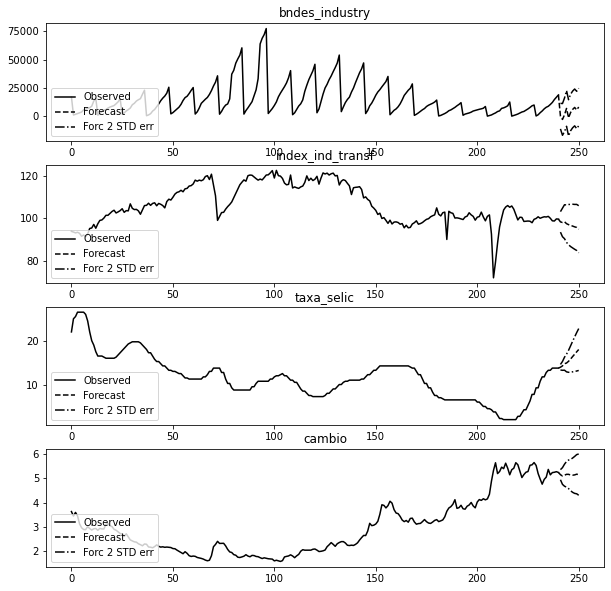

In [96]:
vecm_res.plot_forecast(steps=10, plot_conf_int=True)

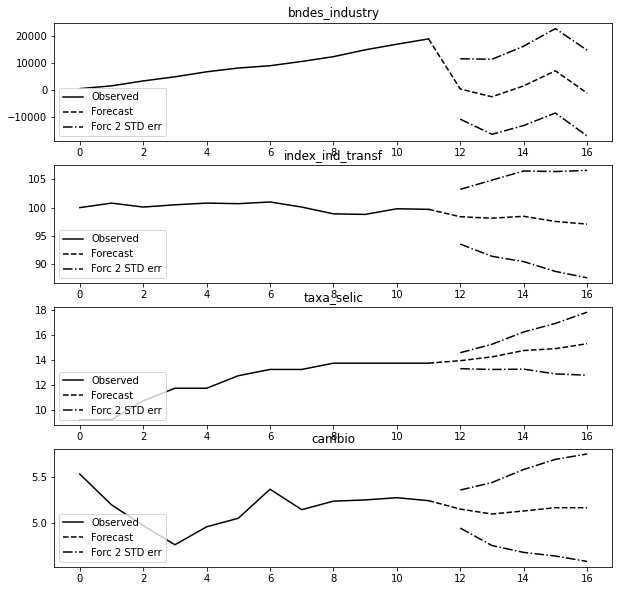

In [98]:
vecm_res.plot_forecast(steps=5, n_last_obs=12)

#### Alternative representations
##### VAR-representation

In [99]:
print(vecm_res.var_rep[0])  # A_1
vecm_res.var_rep

[[ 7.25053480e-01  1.24773716e+02 -6.91685499e+02 -4.89972898e+03]
 [ 4.73077173e-05  8.83131593e-01 -6.36184782e-02 -5.01458203e+00]
 [ 2.43766834e-06  5.84375018e-03  1.22494824e+00  2.96724566e-01]
 [-1.33633351e-06 -6.58079717e-03  1.87308853e-02  1.27666025e+00]]


array([[[ 7.25053480e-01,  1.24773716e+02, -6.91685499e+02,
         -4.89972898e+03],
        [ 4.73077173e-05,  8.83131593e-01, -6.36184782e-02,
         -5.01458203e+00],
        [ 2.43766834e-06,  5.84375018e-03,  1.22494824e+00,
          2.96724566e-01],
        [-1.33633351e-06, -6.58079717e-03,  1.87308853e-02,
          1.27666025e+00]],

       [[-1.34801130e-01, -1.99803038e+02,  2.95528094e+03,
          7.06594031e+03],
        [-4.96890410e-05, -4.13458294e-02, -2.11267951e-01,
          4.40727686e+00],
        [ 5.76926831e-06,  1.44285213e-02,  1.70610449e-01,
         -8.62854577e-01],
        [ 1.60244096e-06,  1.04505215e-02, -6.50228579e-03,
         -2.78367118e-01]],

       [[ 2.46287274e-01,  3.52684616e+02, -3.29996430e+03,
         -8.61990277e+03],
        [ 2.04621676e-05, -3.65945307e-03,  8.61370870e-02,
          1.23408251e-01],
        [-5.28628296e-06,  5.16165323e-03, -1.67299770e-01,
          1.47268127e+00],
        [ 5.90345351e-07, -5.66840264e-

#### MA-representation

In [100]:
vecm_res.ma_rep(maxn=2)

array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]],

       [[ 7.25053480e-01,  1.24773716e+02, -6.91685499e+02,
         -4.89972898e+03],
        [ 4.73077173e-05,  8.83131593e-01, -6.36184782e-02,
         -5.01458203e+00],
        [ 2.43766834e-06,  5.84375018e-03,  1.22494824e+00,
          2.96724566e-01],
        [-1.33633351e-06, -6.58079717e-03,  1.87308853e-02,
          1.27666025e+00]],

       [[ 4.01665750e-01,  2.90582753e+01,  1.50677885e+03,
         -3.57284258e+03],
        [ 3.29365971e-05,  7.77106518e-01, -4.72030405e-01,
         -6.67384867e+00],
        [ 1.04026573e-05,  2.50990860e-02,  1.67460869e+00,
         -1.61813761e-01],
        [-1.33817899e-06, -3.81991120e-

#### Structural analysis
##### Granger causality

In [102]:
granger_results = vecm_res.test_granger_causality(caused="index_ind_transf", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.277,1.452,0.139,"(33, 752)"


In [103]:
print(granger_results)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: ['bndes_industry', 'taxa_selic', 'cambio'] do not Granger-cause index_ind_transf: fail to reject at 5% significance level. Test statistic: 1.277, critical value: 1.452>, p-value: 0.139>


In [104]:
granger_results.signif, granger_results.pvalue

(0.05, 0.13907557307486743)

#### Instantaneous causality

In [111]:
inst_caus_ind_transf_bndes = vecm_res.test_inst_causality(causing="index_ind_transf")
inst_caus_bndes_ind_transf = vecm_res.test_inst_causality(causing="bndes_industry")
inst_caus_bndes_ind_transf.summary()

Test statistic,Critical value,p-value,df
1.437,7.815,0.697,3


In [112]:
inst_caus_ind_transf_bndes  == inst_caus_bndes_ind_transf

False

In [113]:
granger_results == vecm_res.test_granger_causality(caused="index_ind_transf", signif=0.05)

True

#### Impulse-Response-Analysis

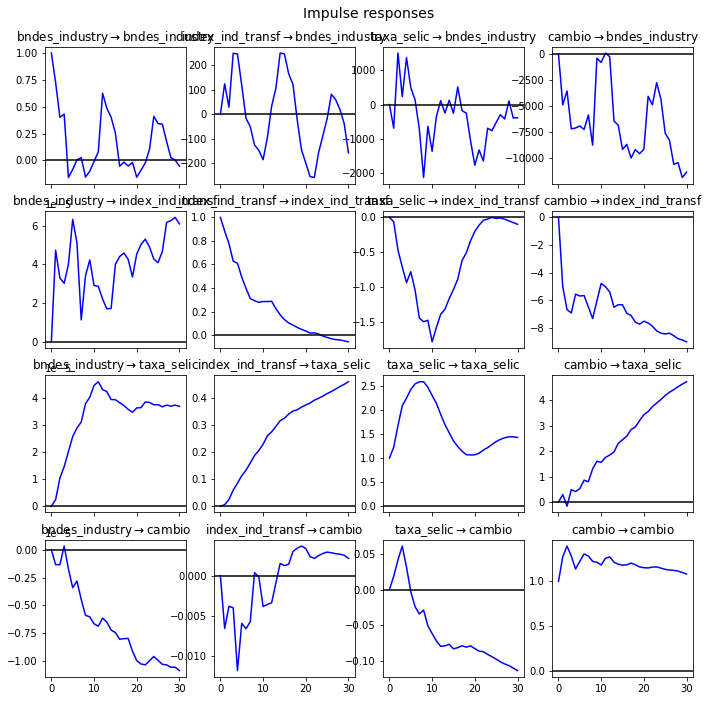

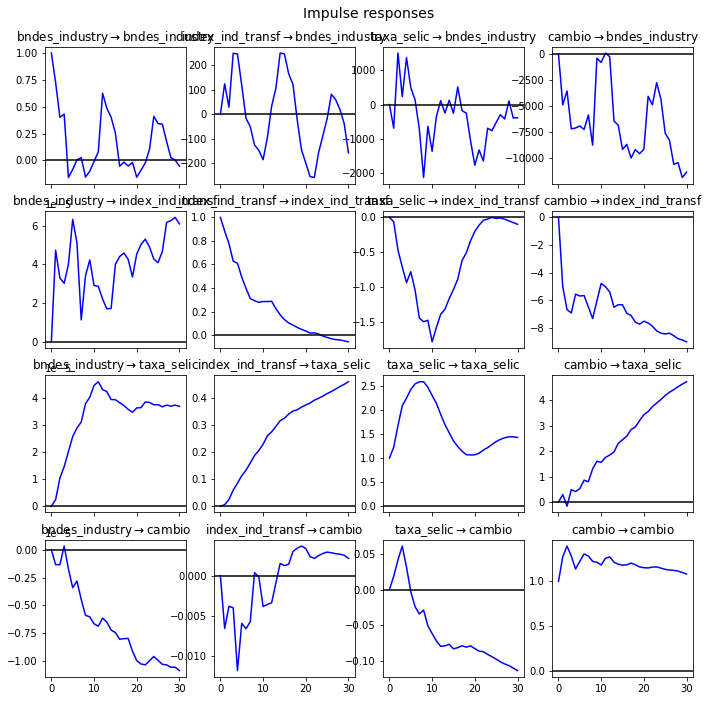

In [114]:
num_periods = 30
ir = vecm_res.irf(periods=num_periods)
ir.plot(plot_stderr=False)

#### Testing for Nonnormality

In [115]:
norm_test = vecm_res.test_normality()
norm_test.summary()

Test statistic,Critical value,p-value,df
2283.,15.51,0.000,8


In [117]:
print(norm_test);

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 2283.150, critical value: 15.507>, p-value: 0.000>


In [118]:
norm_test.test_statistic, norm_test.crit_value, norm_test.pvalue

(2283.150072295108, 15.507313055865453, 0.0)

#### Checking for residual autocorrelation

In [119]:
white_test = vecm_res.test_whiteness(nlags=12, adjusted=True)
white_test.summary()

Test statistic,Critical value,p-value,df
268.4,36.42,0.000,24


In [120]:
white_test.test_statistic, white_test.crit_value, white_test.pvalue

(268.3611637824236, 36.41502850180731, 3.684533201378947e-43)